In [1]:
import pandas as pd
df = pd.read_csv('ultimate.csv')

In [12]:
import pandas as pd

def process_csv():
    # 1. Read the CSV
    df = pd.read_csv('ultimate.csv')

    # Ensure required columns exist
    if 'dd_mobile_own_5' not in df.columns or 'dd_mobile_own_4' not in df.columns:
        print("Error: Columns 'dd_mobile_gap_5' or 'dd_mobile_gap_4' not found in the CSV.")
        return

    # 2. Calculate the difference
    difference = df['dd_mobile_own_5'] - df['dd_mobile_own_4']

    # 3. Create treatment_status column
    df['treatment_status'] = difference.apply(lambda x: 'treated' if x >= -8 else 'non treated')

    # 4. Save the new column back to ultimate.csv
    df.to_csv('ultimate.csv', index=False)
    print(f"Successfully updated 'ultimate.csv'.")

    # 5. Give a count of treated and non-treated districts
    print("\n--- Treatment Status Counts ---")
    counts = df['treatment_status'].value_counts()
    print(counts)

if __name__ == "__main__":
    process_csv()

Successfully updated 'ultimate.csv'.

--- Treatment Status Counts ---
treatment_status
non treated    470
treated        230
Name: count, dtype: int64


In [13]:
import pandas as pd
import numpy as np
from scipy import stats

def generate_balance_table():
    # 1. Load the data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # Ensure treatment_status exists
    if 'treatment_status' not in df.columns:
        print("Error: 'treatment_status' column missing. Run the previous script first.")
        return

    # 2. Define the Variable Mapping
    # Format: {'Description for Output': 'Column Name in CSV'}
    
    # Panel A: Individual and Household Characteristics
    panel_a_vars = {
        'Age (Female)': 'f_mean_age',
        'Formal Education (Female)': 'f_mean_education', # Using f_mean_education
        'Literate (Female %)': 'f_pct_literate',
        'Married (Female %)': 'f_pct_married',
        'Household Size': 'f_mean_hh_size',
        'Urban Household (share)': 'urban_share',
        'Wealth Index': 'f_mean_wealth_idx'
    }

    # Panel B: Employment Composition
    # Note: Sector breakdown columns were not in the provided list. 
    # Adding available proxy columns. Add specific columns here if they exist.
    panel_b_vars = {
        'Female LFPR': 'lfpr_percent',
        'Male Currently Working (%)': 'm_pct_currently_working',
        # Placeholders for missing columns - Uncomment and update if you have them:
        # 'Share Agriculture': 'share_agriculture', 
        # 'Share Manufacturing': 'share_manufacturing',
        # 'Share Services': 'share_services',
        # 'Self Employed': 'self_employed_share',
        # 'Wage Employed': 'wage_employed_share'
    }

    # Panel C: Domestic Violence
    panel_c_vars = {
        'Justify Beating (Goes Out)': 'm_justify_beating_goes_out',
        'Justify Beating (Neglects Kids)': 'm_justify_beating_neglect_kids',
        'Experienced Emotional Violence': 'm_experienced_emotional_viol',
        'Experienced Physical Violence (Any)': 'm_experienced_any_physical_viol',
        'Experienced Sexual Violence (Any)': 'm_experienced_any_sexual_viol',
        'Experienced Severe Injury': 'm_experienced_any_listed_injury',
        'Husband Drinks Alcohol': 'm_hp_drinks_alcohol'
    }

    # 3. Helper function to calculate stats
    def calculate_panel(var_dict, panel_name):
        results = []
        
        # Split data
        treated = df[df['treatment_status'] == 'treated']
        control = df[df['treatment_status'] == 'non treated']
        
        N_t = len(treated)
        N_c = len(control)

        for label, col in var_dict.items():
            if col not in df.columns:
                results.append({
                    'Variable': label,
                    'Treated (Mean)': 'N/A',
                    'Non-Treated (Mean)': 'N/A',
                    'T-stat': 'N/A',
                    'Nt': N_t,
                    'Nc': N_c
                })
                continue

            # Get data, drop NaNs for calculation
            t_data = treated[col].dropna()
            c_data = control[col].dropna()

            # Means
            mean_t = t_data.mean()
            mean_c = c_data.mean()

            # T-statistic
            # Equal var=False (Welch's t-test) is safer for different sample sizes/variances
            if len(t_data) > 1 and len(c_data) > 1:
                t_stat, _ = stats.ttest_ind(t_data, c_data, nan_policy='omit', equal_var=False)
            else:
                t_stat = np.nan

            results.append({
                'Variable': label,
                'Treated (Mean)': round(mean_t, 3),
                'Non-Treated (Mean)': round(mean_c, 3),
                'T-stat': round(t_stat, 3),
                'Nt': len(t_data), # Actual N used in calc
                'Nc': len(c_data)  # Actual N used in calc
            })
        
        return pd.DataFrame(results)

    # 4. Generate Panels
    df_a = calculate_panel(panel_a_vars, "Panel A")
    df_b = calculate_panel(panel_b_vars, "Panel B")
    df_c = calculate_panel(panel_c_vars, "Panel C")

    # 5. Display and Save
    print("\n" + "="*50)
    print("PANEL A: Individual and Household Characteristics")
    print("="*50)
    print(df_a.to_string(index=False))

    print("\n" + "="*50)
    print("PANEL B: Employment Composition")
    print("="*50)
    print(df_b.to_string(index=False))

    print("\n" + "="*50)
    print("PANEL C: Domestic Violence Indicators")
    print("="*50)
    print(df_c.to_string(index=False))

    # Optional: Save to CSV
    with open('balance_table_results.txt', 'w') as f:
        f.write("PANEL A\n")
        f.write(df_a.to_string(index=False))
        f.write("\n\nPANEL B\n")
        f.write(df_b.to_string(index=False))
        f.write("\n\nPANEL C\n")
        f.write(df_c.to_string(index=False))
    
    print("\nResults saved to 'balance_table_results.txt'")

if __name__ == "__main__":
    generate_balance_table()


PANEL A: Individual and Household Characteristics
                 Variable  Treated (Mean)  Non-Treated (Mean)  T-stat  Nt  Nc
             Age (Female)          30.550              30.528   0.209 230 470
Formal Education (Female)           1.622               1.570   2.061 230 470
      Literate (Female %)          79.170              77.192   2.069 230 470
       Married (Female %)          71.249              70.712   1.266 230 470
           Household Size           5.405               5.275   2.239 230 470
  Urban Household (share)          27.777              27.117   0.395 230 470
             Wealth Index           3.022               2.909   1.701 230 470

PANEL B: Employment Composition
                  Variable  Treated (Mean)  Non-Treated (Mean)  T-stat  Nt  Nc
               Female LFPR          21.578              21.442   0.117 209 365
Male Currently Working (%)          74.480              74.661  -0.263 230 470

PANEL C: Domestic Violence Indicators
                

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def run_regression_analysis():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Prepare Variables
    # Create the change variable if it doesn't exist explicitly
    # Assuming Gap 5 - Gap 4 based on previous context
    if 'change_in_digital_gap' not in df.columns:
        df['change_in_digital_gap'] = df['dd_mobile_own_5'] - df['dd_mobile_own_4']

    # Define variables for the model
    target = 'lfpr_percent' # Mapping for flpr_2019_20
    
    key_regressors = ['change_in_digital_gap', 'dd_mobile_own_5']
    
    # Mapping controls to your provided column list
    controls = [
        'f_mean_education', # Education
        'f_mean_hh_size',   # HH Size
        'f_mean_age',       # Age
        'f_pct_married',    # Marital Status
        'urban_share',      # Urban/Rural
        'f_pct_sc',         # Caste: SC
        'f_pct_st',         # Caste: ST
        'f_pct_obc'         # Caste: OBC
    ]
    
    # Check if 'state' exists for region control
    if 'state' in df.columns:
        region_control = 'state'
    else:
        print("Warning: 'state' column not found. Running without region fixed effects.")
        region_control = None

    # 3. Data Cleaning
    # Select only necessary columns to drop NaNs efficiently
    cols_to_use = [target] + key_regressors + controls
    if region_control:
        cols_to_use.append(region_control)
        
    # Check for missing columns
    missing_cols = [c for c in cols_to_use if c not in df.columns]
    if missing_cols:
        print(f"Error: The following columns are missing in CSV: {missing_cols}")
        return

    data = df[cols_to_use].dropna()
    print(f"Observations used in regression: {len(data)}")

    # 4. Regression Model (OLS)
    # Create dummies for state (Region FE)
    if region_control:
        # drop_first=True to avoid dummy variable trap
        X = pd.get_dummies(data[key_regressors + controls + [region_control]], 
                           columns=[region_control], 
                           drop_first=True, 
                           dtype=float)
    else:
        X = data[key_regressors + controls]

    # Add constant term
    X = sm.add_constant(X)
    y = data[target]

    model = sm.OLS(y, X).fit()

    # 5. Output Table
    print("\n" + "="*80)
    print("REGRESSION RESULTS: Dependent Variable = FLPR")
    print("="*80)
    print(model.summary())
    
    # Save summary to text file
    with open('regression_summary.txt', 'w') as f:
        f.write(model.summary().as_text())

    # 6. Plotting
    sns.set_style("whitegrid")
    
    # --- Plot 1: Scatter (Change in Gap vs FLPR) ---
    plt.figure(figsize=(10, 6))
    sns.regplot(x='change_in_digital_gap', y=target, data=data, 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Scatter Plot: Change in Digital Gap vs FLPR', fontsize=14)
    plt.xlabel('Change in Digital Gap (Gap 5 - Gap 4)', fontsize=12)
    plt.ylabel('FLPR (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig('scatter_plot_flpr.png')
    print("\nScatter plot saved as 'scatter_plot_flpr.png'")
    plt.close()

    # --- Plot 2: Coefficient Plot (Key Regressors) ---
    # Extract coefficients and confidence intervals
    params = model.params
    conf = model.conf_int()
    conf['Coef'] = params
    conf.columns = ['Lower CI', 'Upper CI', 'Coef']
    
    # Filter for key regressors only
    plot_data = conf.loc[key_regressors]
    
    plt.figure(figsize=(8, 5))
    
    # Create error bars
    errors = [plot_data['Coef'] - plot_data['Lower CI'], plot_data['Upper CI'] - plot_data['Coef']]
    
    plt.errorbar(x=plot_data['Coef'], y=plot_data.index, xerr=errors, fmt='o', capsize=5, color='blue')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    
    plt.title('Regression Coefficients (with 95% CI)', fontsize=14)
    plt.xlabel('Coefficient Estimate', fontsize=12)
    plt.yticks(ticks=range(len(key_regressors)), labels=['Change in Digital Gap', 'Digital Gap (NFHS-5)'])
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('coefficient_plot.png')
    print("Coefficient plot saved as 'coefficient_plot.png'")
    plt.close()

if __name__ == "__main__":
    run_regression_analysis()

Observations used in regression: 516

REGRESSION RESULTS: Dependent Variable = FLPR
                            OLS Regression Results                            
Dep. Variable:           lfpr_percent   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     19.77
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.12e-72
Time:                        23:56:51   Log-Likelihood:                -1828.9
No. Observations:                 516   AIC:                             3730.
Df Residuals:                     480   BIC:                             3883.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

Observations used: 516
                            OLS Regression Results                            
Dep. Variable:           lfpr_percent   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     19.77
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.12e-72
Time:                        21:20:58   Log-Likelihood:                -1828.9
No. Observations:                 516   AIC:                             3730.
Df Residuals:                     480   BIC:                             3883.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
con

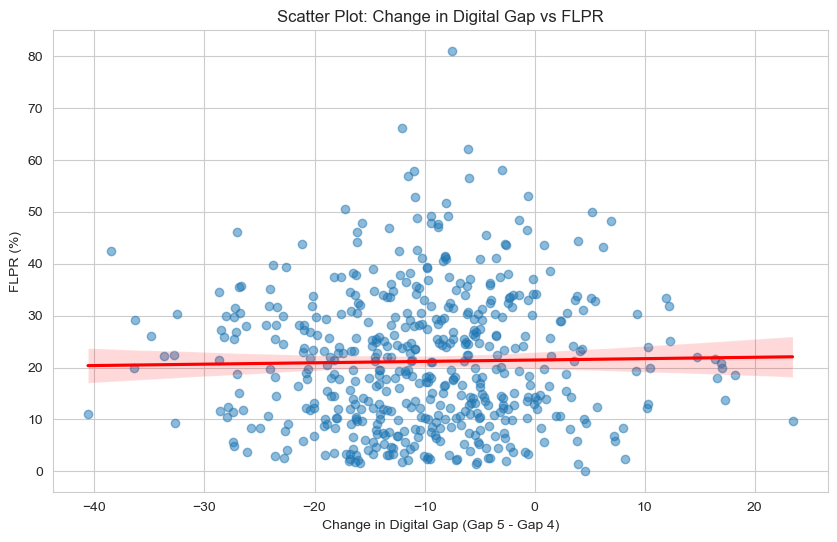

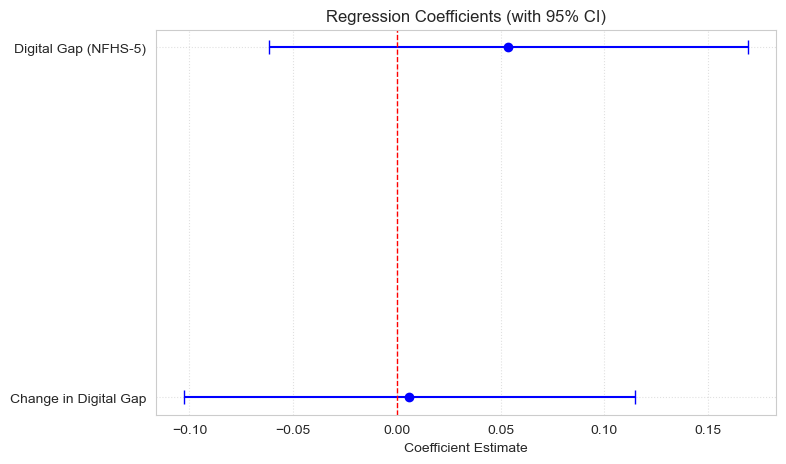

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('ultimate.csv')

# 2. Prepare Variables
# Create the change variable
if 'change_in_digital_gap' not in df.columns:
    df['change_in_digital_gap'] = df['dd_mobile_own_5'] - df['dd_mobile_own_4']

# Define variables
target = 'lfpr_percent'
key_regressors = ['change_in_digital_gap', 'dd_mobile_own_5']
controls = [
    'f_mean_education', 
    'f_mean_hh_size',   
    'f_mean_age',       
    'f_pct_married',    
    'urban_share',      
    'f_pct_sc',         
    'f_pct_st',         
    'f_pct_obc'         
]

# Check if 'state' exists for region control
region_control = 'state' if 'state' in df.columns else None

# 3. Data Cleaning
cols_to_use = [target] + key_regressors + controls
if region_control:
    cols_to_use.append(region_control)

# Drop missing values
data = df[cols_to_use].dropna()
print(f"Observations used: {len(data)}")

# 4. Regression Model (OLS)
if region_control:
    X = pd.get_dummies(data[key_regressors + controls + [region_control]], 
                       columns=[region_control], 
                       drop_first=True, 
                       dtype=float)
else:
    X = data[key_regressors + controls]

X = sm.add_constant(X)
y = data[target]

model = sm.OLS(y, X).fit()

# 5. Output Table
print(model.summary())

# 6. Plotting - Scatter Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.regplot(x='change_in_digital_gap', y=target, data=data, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Scatter Plot: Change in Digital Gap vs FLPR')
plt.xlabel('Change in Digital Gap (Gap 5 - Gap 4)')
plt.ylabel('FLPR (%)')

plt.show()

# 7. Plotting - Coefficient Plot
params = model.params
conf = model.conf_int()
conf['Coef'] = params
conf.columns = ['Lower CI', 'Upper CI', 'Coef']

# Filter for key regressors only
plot_data = conf.loc[key_regressors]

plt.figure(figsize=(8, 5))

# Calculate error bar lengths
errors = [plot_data['Coef'] - plot_data['Lower CI'], plot_data['Upper CI'] - plot_data['Coef']]

plt.errorbar(x=plot_data['Coef'], y=plot_data.index, xerr=errors, fmt='o', capsize=5, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

plt.title('Regression Coefficients (with 95% CI)')
plt.xlabel('Coefficient Estimate')
plt.yticks(ticks=range(len(key_regressors)), labels=['Change in Digital Gap', 'Digital Gap (NFHS-5)'])
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

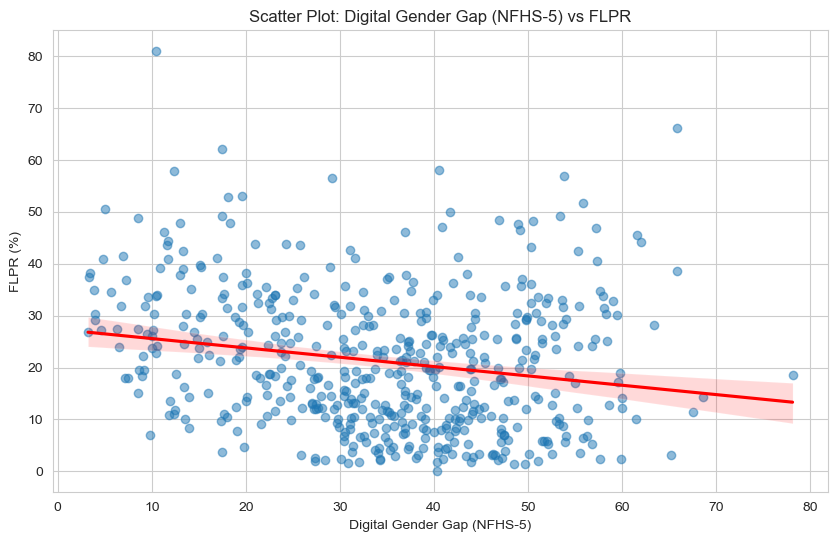

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# x = dd_mobile_gap_5 (Digital Gender Gap NFHS-5)
# y = lfpr_percent (LFPR)
sns.regplot(x='dd_mobile_own_5', y='lfpr_percent', data=df, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Scatter Plot: Digital Gender Gap (NFHS-5) vs FLPR')
plt.xlabel('Digital Gender Gap (NFHS-5)')
plt.ylabel('FLPR (%)')

plt.show()

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_mobile_own_regression():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Define Variables
    target = 'lfpr_percent'
    main_regressor = 'dd_mobile_own_5'

    # Standard controls used in previous analysis
    controls = [
        'f_mean_education', 
        'f_mean_hh_size',   
        'f_mean_age',       
        'f_pct_married',    
        'urban_share',      
        'f_pct_sc',         
        'f_pct_st',         
        'f_pct_obc'         
    ]

    # Check if 'state' exists for region control (Fixed Effects)
    region_control = 'state' if 'state' in df.columns else None

    # 3. Data Cleaning
    cols_to_use = [target, main_regressor] + controls
    if region_control:
        cols_to_use.append(region_control)

    # Check for missing columns
    missing_cols = [c for c in cols_to_use if c not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return

    # Drop missing values
    data = df[cols_to_use].dropna()
    print(f"Observations used: {len(data)}")

    # 4. Regression Model (OLS)
    # Create dummies for state (Region Fixed Effects)
    if region_control:
        X = pd.get_dummies(data[[main_regressor] + controls + [region_control]], 
                           columns=[region_control], 
                           drop_first=True, 
                           dtype=float)
    else:
        X = data[[main_regressor] + controls]

    # Add constant (intercept)
    X = sm.add_constant(X)
    y = data[target]

    # Fit the model
    model = sm.OLS(y, X).fit()

    # 5. Output Table
    print("\n" + "="*80)
    print(f"REGRESSION RESULTS: {target} ~ {main_regressor} + Controls")
    print("="*80)
    print(model.summary())

if __name__ == "__main__":
    run_mobile_own_regression()

Observations used: 516

REGRESSION RESULTS: lfpr_percent ~ dd_mobile_own_5 + Controls
                            OLS Regression Results                            
Dep. Variable:           lfpr_percent   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     20.40
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.35e-72
Time:                        21:25:27   Log-Likelihood:                -1828.9
No. Observations:                 516   AIC:                             3728.
Df Residuals:                     481   BIC:                             3876.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


############################################################
PART 2: CHILD NUTRITION (BREASTFEEDING)
############################################################

Running Regression for: Breastfeeding %
                               OLS Regression Results                              
Dep. Variable:     f_pct_ever_breastfed_c1   R-squared:                       0.783
Model:                                 OLS   Adj. R-squared:                  0.766
Method:                      Least Squares   F-statistic:                     45.18
Date:                     Sun, 23 Nov 2025   Prob (F-statistic):          5.53e-147
Time:                             21:27:44   Log-Likelihood:                -1752.2
No. Observations:                      569   AIC:                             3590.
Df Residuals:                          526   BIC:                             3777.
Df Model:                               42                                         
Covariance Type:                 nonrobu

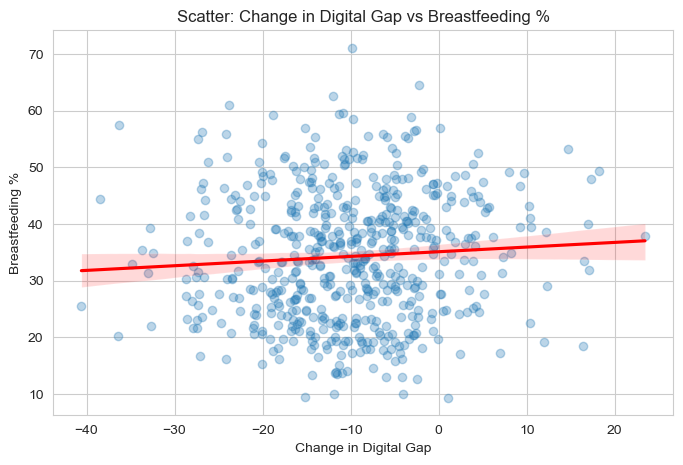


Running Regression for: Breastfeeding Duration
                            OLS Regression Results                            
Dep. Variable:       f_mean_bf_dur_c1   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     42.22
Date:                Sun, 23 Nov 2025   Prob (F-statistic):          4.20e-141
Time:                        21:27:45   Log-Likelihood:                -1657.5
No. Observations:                 569   AIC:                             3401.
Df Residuals:                     526   BIC:                             3588.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

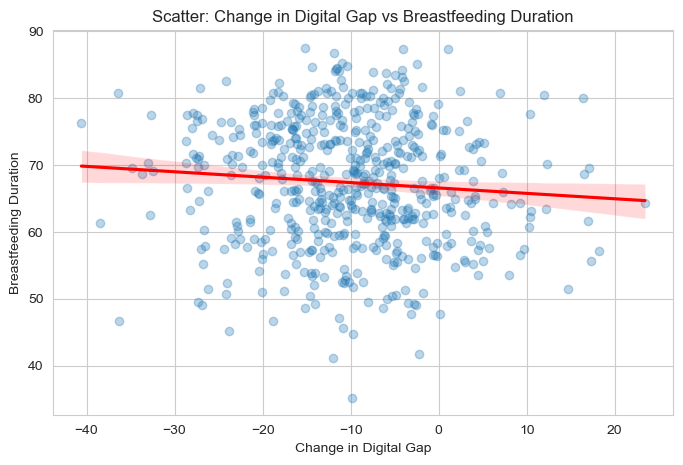

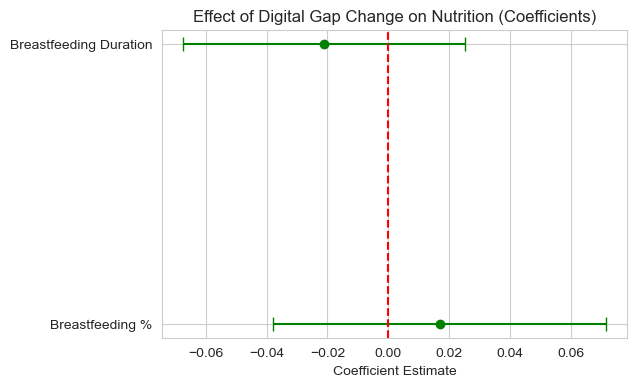

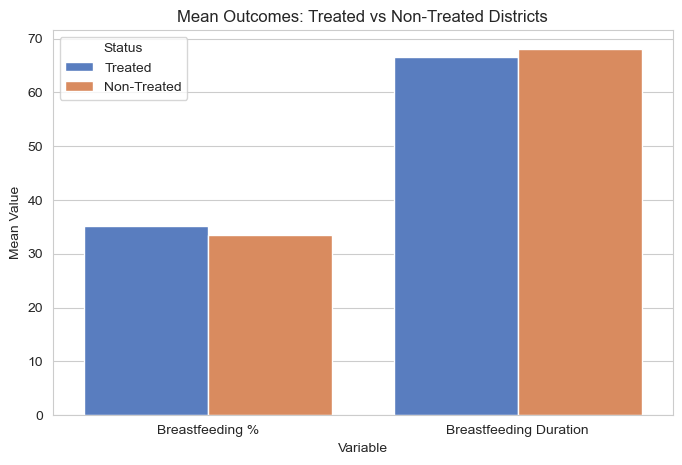


############################################################
PART 3: DOMESTIC VIOLENCE
############################################################

Running Regression for: Ever Slapped
                            OLS Regression Results                            
Dep. Variable:              m_slapped   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     15.35
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.30e-67
Time:                        21:27:46   Log-Likelihood:                 224.00
No. Observations:                 569   AIC:                            -362.0
Df Residuals:                     526   BIC:                            -175.2
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       

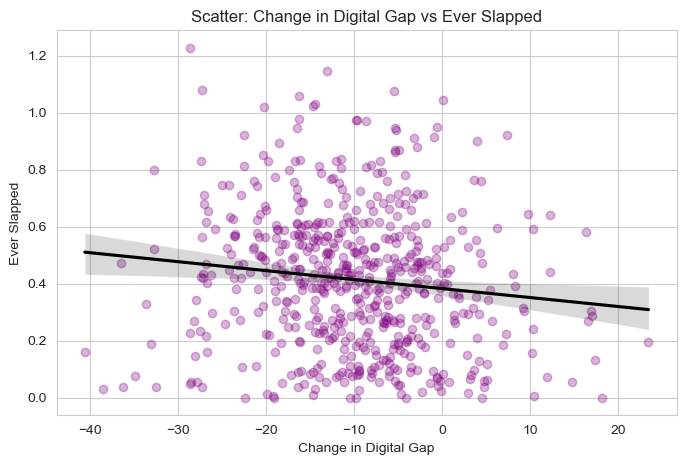


Running Regression for: Ever Hit
                              OLS Regression Results                             
Dep. Variable:     m_punched_hit_harmful   R-squared:                       0.408
Model:                               OLS   Adj. R-squared:                  0.361
Method:                    Least Squares   F-statistic:                     8.641
Date:                   Sun, 23 Nov 2025   Prob (F-statistic):           4.86e-38
Time:                           21:27:47   Log-Likelihood:                 685.45
No. Observations:                    569   AIC:                            -1285.
Df Residuals:                        526   BIC:                            -1098.
Df Model:                             42                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

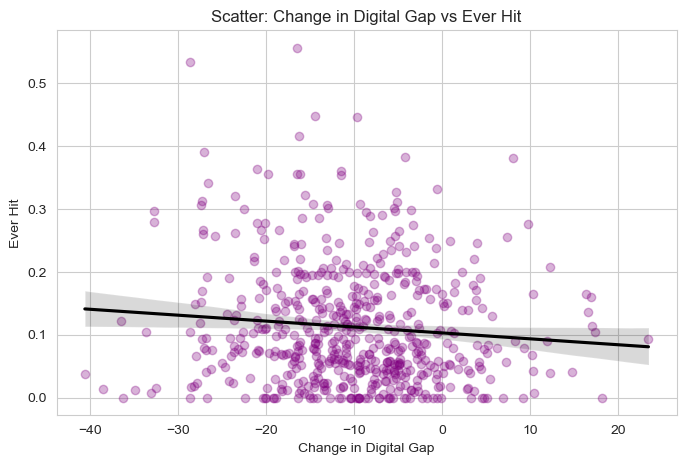


Running Regression for: Sexual Violence
                                  OLS Regression Results                                 
Dep. Variable:     m_experienced_any_sexual_viol   R-squared:                       0.285
Model:                                       OLS   Adj. R-squared:                  0.228
Method:                            Least Squares   F-statistic:                     4.983
Date:                           Sun, 23 Nov 2025   Prob (F-statistic):           1.86e-19
Time:                                   21:27:47   Log-Likelihood:                -1261.9
No. Observations:                            569   AIC:                             2610.
Df Residuals:                                526   BIC:                             2797.
Df Model:                                     42                                         
Covariance Type:                       nonrobust                                         
                                                 coef    st

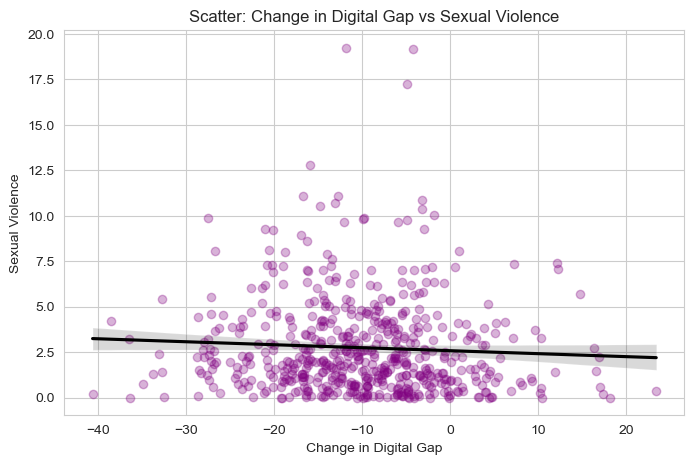

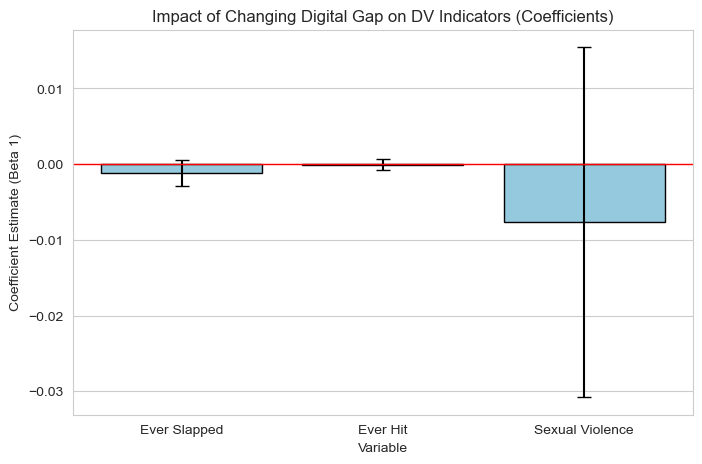

In [23]:
def run_additional_analyses():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Variable Prep
    # Create Regressor: Change in Digital Gap
    if 'change_in_digital_gap' not in df.columns:
        if 'dd_mobile_own_5' in df.columns and 'dd_mobile_own_4' in df.columns:
            df['change_in_digital_gap'] = df['dd_mobile_own_5'] - df['dd_mobile_own_4']
        else:
            print("Error: Cannot calculate change_in_digital_gap. Columns missing.")
            return

    # Create Treatment Status (for mean diff bars) if not exists
    if 'treatment_status' not in df.columns:
        df['treatment_status'] = df['change_in_digital_gap'].apply(lambda x: 'Treated' if x >= -8 else 'Non-Treated')

    # Controls
    controls = [
        'f_mean_education', 'f_mean_hh_size', 'f_mean_age', 'f_pct_married',
        'urban_share', 'f_pct_sc', 'f_pct_st', 'f_pct_obc'
    ]
    
    region_control = 'state' if 'state' in df.columns else None

    # Common function to run regression and get result
    def run_ols(data, target_col, regressor, ctrl_vars, region_fe):
        cols = [target_col, regressor] + ctrl_vars
        if region_fe: cols.append(region_fe)
        
        subset = data[cols].dropna()
        
        if region_fe:
            X = pd.get_dummies(subset[[regressor] + ctrl_vars + [region_fe]], 
                               columns=[region_fe], drop_first=True, dtype=float)
        else:
            X = subset[[regressor] + ctrl_vars]
            
        X = sm.add_constant(X)
        y = subset[target_col]
        
        model = sm.OLS(y, X).fit()
        return model, subset

    sns.set_style("whitegrid")

    # ==========================================
    # PART 2: CHILD NUTRITION (Breastfeeding)
    # ==========================================
    print("\n" + "#"*60)
    print("PART 2: CHILD NUTRITION (BREASTFEEDING)")
    print("#"*60)

    # Variable Mapping
    # Dependent 1: breastfeeding_percentage_nfhs5 -> f_pct_ever_breastfed_c1
    # Dependent 2: breastfeeding_duration_nfhs5 -> f_mean_bf_dur_c1
    nutri_vars = {
        'Breastfeeding %': 'f_pct_ever_breastfed_c1',
        'Breastfeeding Duration': 'f_mean_bf_dur_c1'
    }

    nutri_coeffs = []
    nutri_cis = []

    for label, var in nutri_vars.items():
        if var not in df.columns:
            print(f"Skipping {label}: Column {var} not found.")
            continue

        print(f"\nRunning Regression for: {label}")
        model, valid_data = run_ols(df, var, 'change_in_digital_gap', controls, region_control)
        print(model.summary())

        # Store for Coefficient Plot
        coef = model.params['change_in_digital_gap']
        conf = model.conf_int().loc['change_in_digital_gap']
        nutri_coeffs.append({'Variable': label, 'Coef': coef, 'Lower': conf[0], 'Upper': conf[1]})

        # PLOT 1: Scatter
        plt.figure(figsize=(8, 5))
        sns.regplot(x='change_in_digital_gap', y=var, data=valid_data, 
                    scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title(f'Scatter: Change in Digital Gap vs {label}')
        plt.xlabel('Change in Digital Gap')
        plt.ylabel(label)
        plt.show()

    # PLOT 2: Coefficient Plot (Nutrition)
    if nutri_coeffs:
        c_df = pd.DataFrame(nutri_coeffs)
        plt.figure(figsize=(6, 4))
        errors = [c_df['Coef'] - c_df['Lower'], c_df['Upper'] - c_df['Coef']]
        plt.errorbar(x=c_df['Coef'], y=c_df['Variable'], xerr=errors, fmt='o', capsize=5, color='green')
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Effect of Digital Gap Change on Nutrition (Coefficients)')
        plt.xlabel('Coefficient Estimate')
        plt.show()

    # PLOT 3: Mean Difference Bars (Treated vs Non-Treated)
    # Re-using the valid data subset logic simply for the bar chart
    mean_diff_data = []
    for label, var in nutri_vars.items():
        if var not in df.columns: continue
        # Calculate means
        grp = df.groupby('treatment_status')[var].mean()
        # Check if keys exist
        t_val = grp.get('treated', grp.get('Treated', 0)) # Handle case sensitivity
        nt_val = grp.get('non treated', grp.get('Non-Treated', 0))
        
        mean_diff_data.append({'Variable': label, 'Status': 'Treated', 'Mean': t_val})
        mean_diff_data.append({'Variable': label, 'Status': 'Non-Treated', 'Mean': nt_val})
    
    if mean_diff_data:
        md_df = pd.DataFrame(mean_diff_data)
        plt.figure(figsize=(8, 5))
        sns.barplot(x='Variable', y='Mean', hue='Status', data=md_df, palette='muted')
        plt.title('Mean Outcomes: Treated vs Non-Treated Districts')
        plt.ylabel('Mean Value')
        plt.show()

    # ==========================================
    # PART 3: DOMESTIC VIOLENCE
    # ==========================================
    print("\n" + "#"*60)
    print("PART 3: DOMESTIC VIOLENCE")
    print("#"*60)

    # Variable Mapping
    dv_vars = {
        'Ever Slapped': 'm_slapped',
        'Ever Hit': 'm_punched_hit_harmful',
        'Sexual Violence': 'm_experienced_any_sexual_viol'
    }

    dv_coeffs = []

    for label, var in dv_vars.items():
        if var not in df.columns:
            print(f"Skipping {label}: Column {var} not found.")
            continue

        print(f"\nRunning Regression for: {label}")
        model, valid_data = run_ols(df, var, 'change_in_digital_gap', controls, region_control)
        print(model.summary())

        # Store for Coefficient Bar Chart
        coef = model.params['change_in_digital_gap']
        conf = model.conf_int().loc['change_in_digital_gap']
        dv_coeffs.append({'Variable': label, 'Coef': coef, 'Lower': conf[0], 'Upper': conf[1]})

        # PLOT 1: Scatter (Three independent scatters requested)
        plt.figure(figsize=(8, 5))
        sns.regplot(x='change_in_digital_gap', y=var, data=valid_data, 
                    scatter_kws={'alpha':0.3, 'color': 'purple'}, line_kws={'color':'black'})
        plt.title(f'Scatter: Change in Digital Gap vs {label}')
        plt.xlabel('Change in Digital Gap')
        plt.ylabel(label)
        plt.show()

    # PLOT 2: Coefficient Bar Chart (Comparing Beta_1 across indicators)
    if dv_coeffs:
        dv_df = pd.DataFrame(dv_coeffs)
        plt.figure(figsize=(8, 5))
        
        # Using a bar chart for coefficients as requested
        sns.barplot(x='Variable', y='Coef', data=dv_df, color='skyblue', edgecolor='black')
        
        # Adding error bars manually on top of the bars
        # This can be tricky with barplot, so we use errorbar overlay
        plt.errorbar(x=range(len(dv_df)), y=dv_df['Coef'], 
                     yerr=[dv_df['Coef'] - dv_df['Lower'], dv_df['Upper'] - dv_df['Coef']], 
                     fmt='none', c='black', capsize=5)
        
        plt.axhline(y=0, color='red', linestyle='-', linewidth=1)
        plt.title('Impact of Changing Digital Gap on DV Indicators (Coefficients)')
        plt.ylabel('Coefficient Estimate (Beta 1)')
        plt.show()

if __name__ == "__main__":
    run_additional_analyses()

Generating Plots...

--- Processing Child Nutrition ---
Plotting: Breastfeeding Percentage (%)


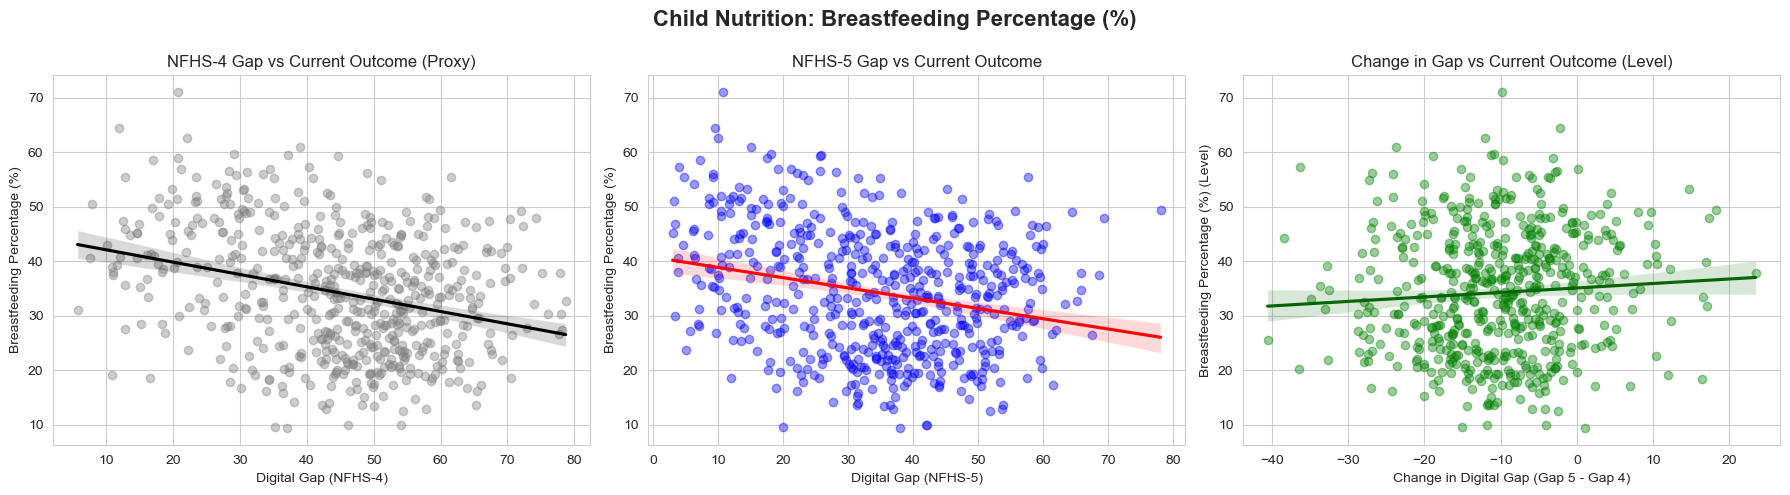

Plotting: Breastfeeding Duration (Months)


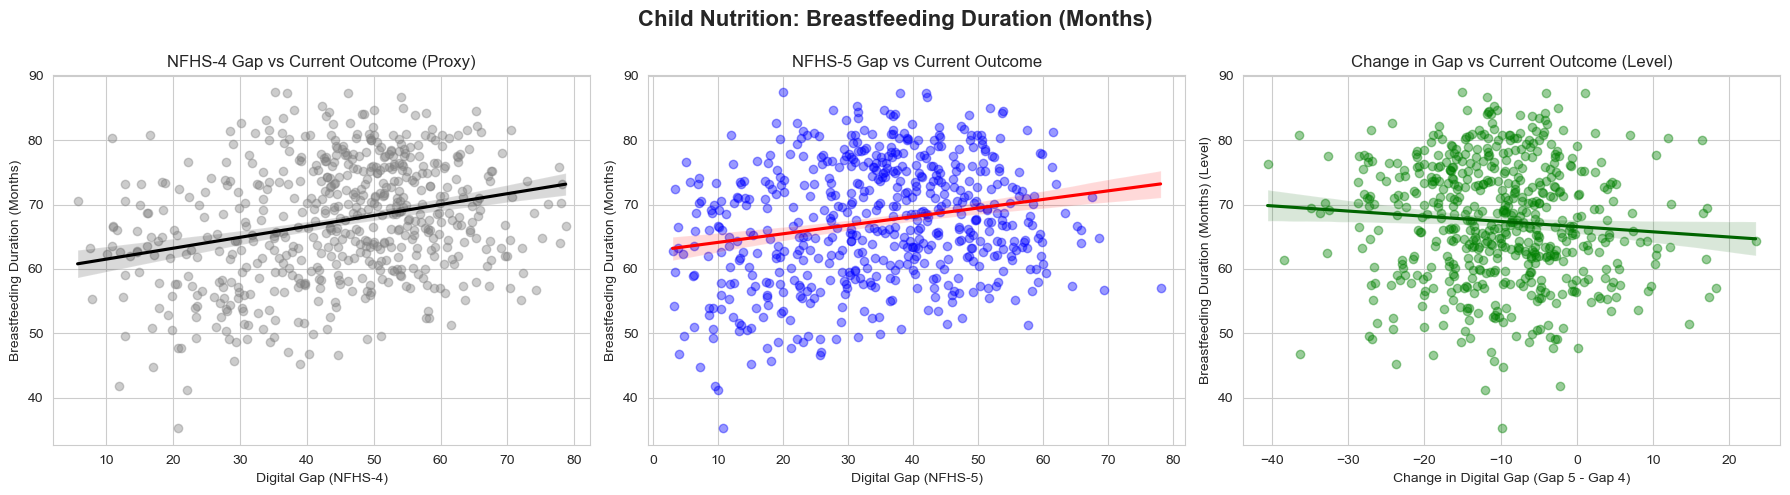


--- Processing Domestic Violence ---
Plotting: Ever Slapped (%)


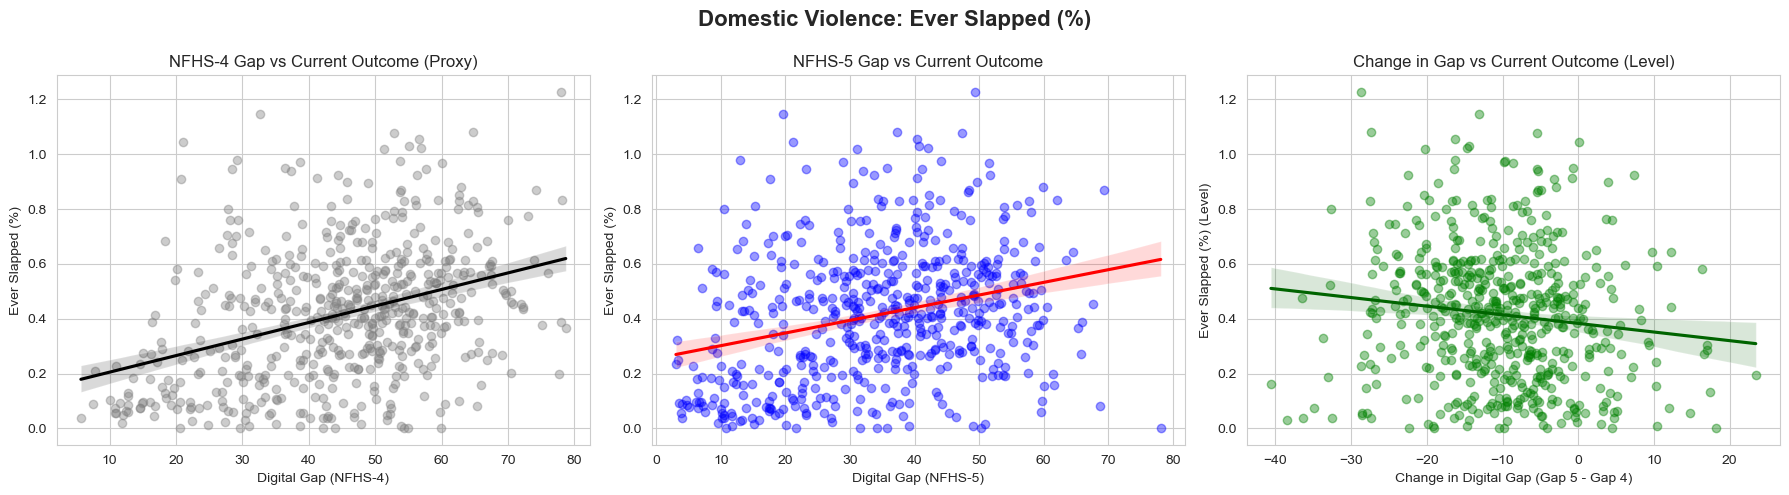

Plotting: Ever Hit (%)


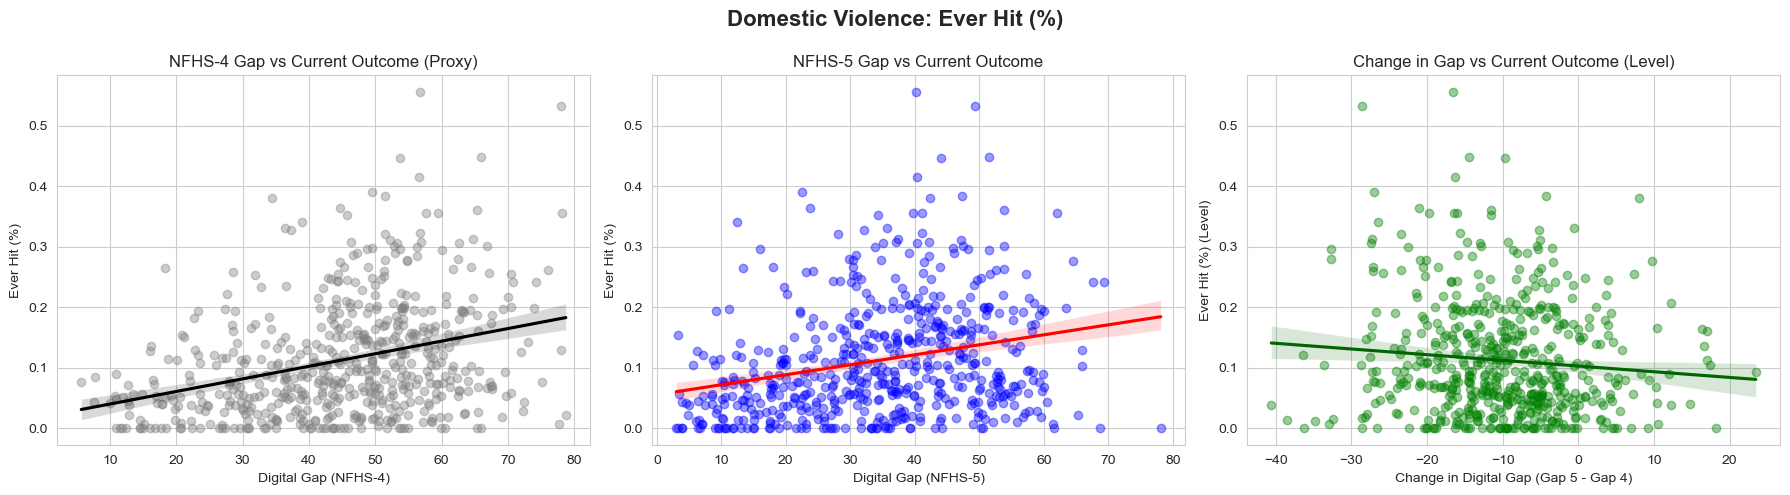

Plotting: Sexual Violence (%)


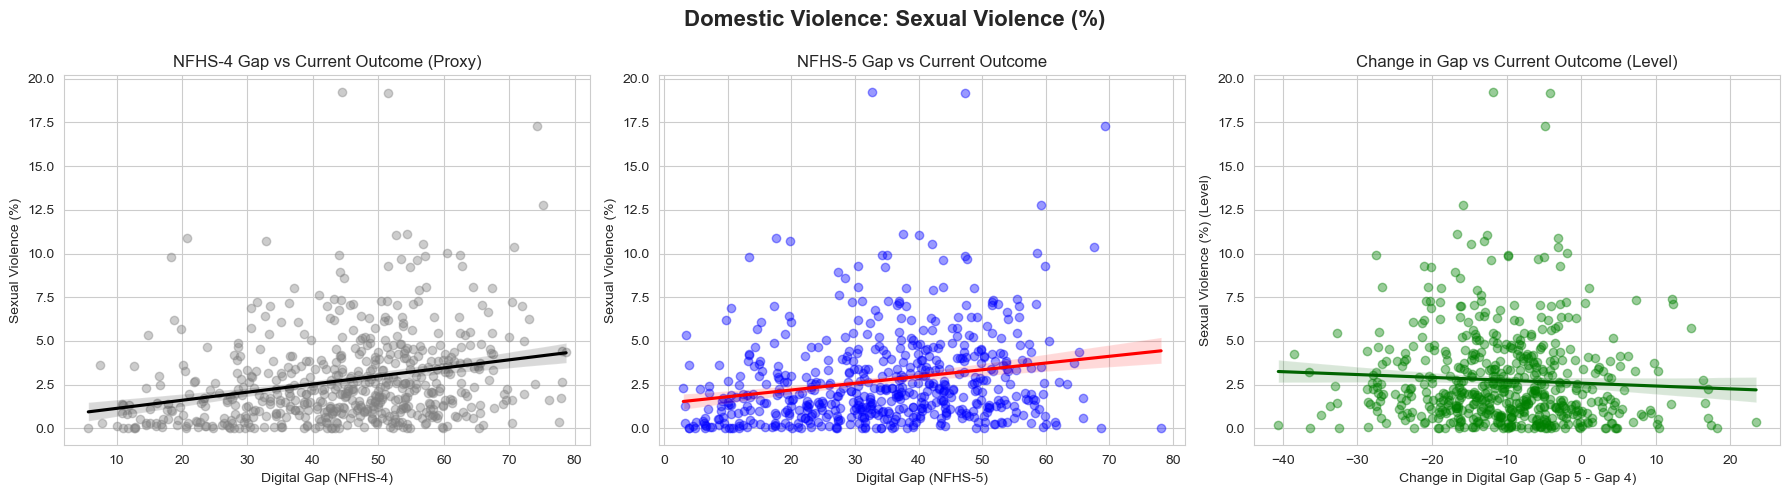

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def run_comprehensive_plotting():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Prepare Digital Gap Variables
    # NFHS-5 Gap
    gap_5 = 'dd_mobile_own_5'
    
    # NFHS-4 Gap
    gap_4 = 'dd_mobile_own_4'
    
    # Change in Gap
    change_gap = 'change_in_digital_gap'
    if change_gap not in df.columns:
        if gap_5 in df.columns and gap_4 in df.columns:
            df[change_gap] = df[gap_5] - df[gap_4]
        else:
            print("Error: Digital Gap columns (4 and 5) missing. Cannot calculate change.")
            return

    # 3. Define Outcome Categories
    # Included specifically: Percentage (Prevalence) and Duration for Nutrition
    outcomes = {
        'Child Nutrition': {
            'Breastfeeding Percentage (%)': 'f_pct_ever_breastfed_c1', # Percentage
            'Breastfeeding Duration (Months)': 'f_mean_bf_dur_c1'      # Duration
        },
        'Domestic Violence': {
            'Ever Slapped (%)': 'm_slapped',
            'Ever Hit (%)': 'm_punched_hit_harmful',
            'Sexual Violence (%)': 'm_experienced_any_sexual_viol'
        }
    }

    sns.set_style("whitegrid")

    # 4. Helper Function for Plotting
    def plot_row(category_name, var_label, col_current):
        """
        Plots 3 graphs per outcome variable:
        1. Old DGG (NFHS-4) vs Old Outcome (if avail) OR Current Outcome
        2. New DGG (NFHS-5) vs Current Outcome
        3. Change in DGG vs Change in Outcome (if avail) OR Current Outcome
        """
        
        # Attempt to find the "Old" (NFHS-4) version of the column
        # Common pattern: col_name ending in _4 or similar if it existed
        # Since provided list didn't have them, this is a placeholder for robustness
        col_old = None
        potential_suffixes = ['_4', '_nfhs4', '_old']
        for suffix in potential_suffixes:
            check_col = col_current + suffix
            if check_col in df.columns:
                col_old = check_col
                break
                
        # Setup Figure - 1 Row, 3 Columns
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'{category_name}: {var_label}', fontsize=16, weight='bold')

        # --- Plot 1: Old Regression (NFHS-4) ---
        # X: Gap 4
        # Y: Outcome 4 (Ideal) or Outcome 5 (Proxy)
        if gap_4 in df.columns:
            x_var = gap_4
            if col_old:
                y_var = col_old
                title = "NFHS 4 Digital Gender Gap vs NFHS-4 Outcome"
                color = 'gray'
            else:
                y_var = col_current
                title = "NFHS 4 Digital Gender Gap vs NFHS-4 Outcome"
                color = 'gray'
            
            # Filter NaNs for plotting
            subset = df[[x_var, y_var]].dropna()
            if not subset.empty:
                sns.regplot(ax=axes[0], x=x_var, y=y_var, data=subset,
                            scatter_kws={'alpha':0.4, 'color':color}, line_kws={'color':'black'})
                axes[0].set_title(title)
                axes[0].set_xlabel("Digital Gap (NFHS-4)")
                axes[0].set_ylabel(var_label)
            else:
                axes[0].text(0.5, 0.5, "No Data", ha='center')

        # --- Plot 2: New Regression (NFHS-5) ---
        # X: Gap 5
        # Y: Outcome 5
        if gap_5 in df.columns:
            subset = df[[gap_5, col_current]].dropna()
            if not subset.empty:
                sns.regplot(ax=axes[1], x=gap_5, y=col_current, data=subset,
                            scatter_kws={'alpha':0.4, 'color':'blue'}, line_kws={'color':'red'})
                axes[1].set_title("NFHS-5 Digital Gap vs NFHS-5 Outcome")
                axes[1].set_xlabel("Digital Gap (NFHS-5)")
                axes[1].set_ylabel(var_label)

        # --- Plot 3: Change Analysis ---
        # X: Change in Gap
        # Y: Change in Outcome (Ideal) or Current Outcome (Proxy)
        x_var = change_gap
        
        if col_old:
            # Calculate Change in Outcome
            change_col_out = f'change_{col_current}'
            df[change_col_out] = df[col_current] - df[col_old]
            y_var = change_col_out
            title = "Change in Gap vs Change in Outcome"
            ylabel = f"Change in {var_label}"
            color = 'green'
        else:
            y_var = col_current
            title = "Change in Gap vs Current Outcome"
            ylabel = f"{var_label} (Level)"
            color = 'green'

        subset = df[[x_var, y_var]].dropna()
        if not subset.empty:
            sns.regplot(ax=axes[2], x=x_var, y=y_var, data=subset,
                        scatter_kws={'alpha':0.4, 'color':color}, line_kws={'color':'darkgreen'})
            axes[2].set_title(title)
            axes[2].set_xlabel("Change in Digital Gap (Gap 5 - Gap 4)")
            axes[2].set_ylabel(ylabel)

        plt.tight_layout()
        plt.subplots_adjust(top=0.85) # Adjust for suptitle
        plt.show()

    # 5. Execute Loop
    print("Generating Plots...")
    
    for cat, vars_dict in outcomes.items():
        print(f"\n--- Processing {cat} ---")
        for label, col in vars_dict.items():
            if col in df.columns:
                print(f"Plotting: {label}")
                plot_row(cat, label, col)
            else:
                print(f"Warning: Column '{col}' for {label} not found in CSV.")

if __name__ == "__main__":
    run_comprehensive_plotting()

Generating Plots...

--- Processing Child Nutrition ---
Plotting: Breastfeeding Percentage (%)


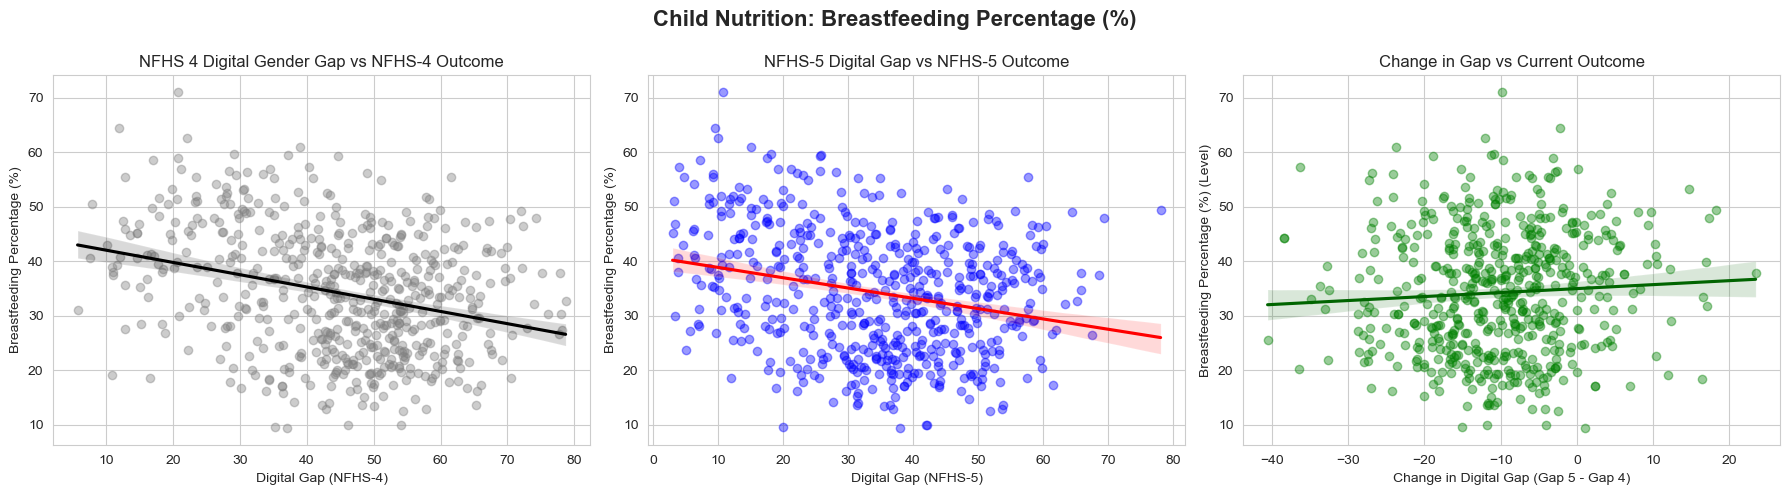

Plotting: Breastfeeding Duration (Months)


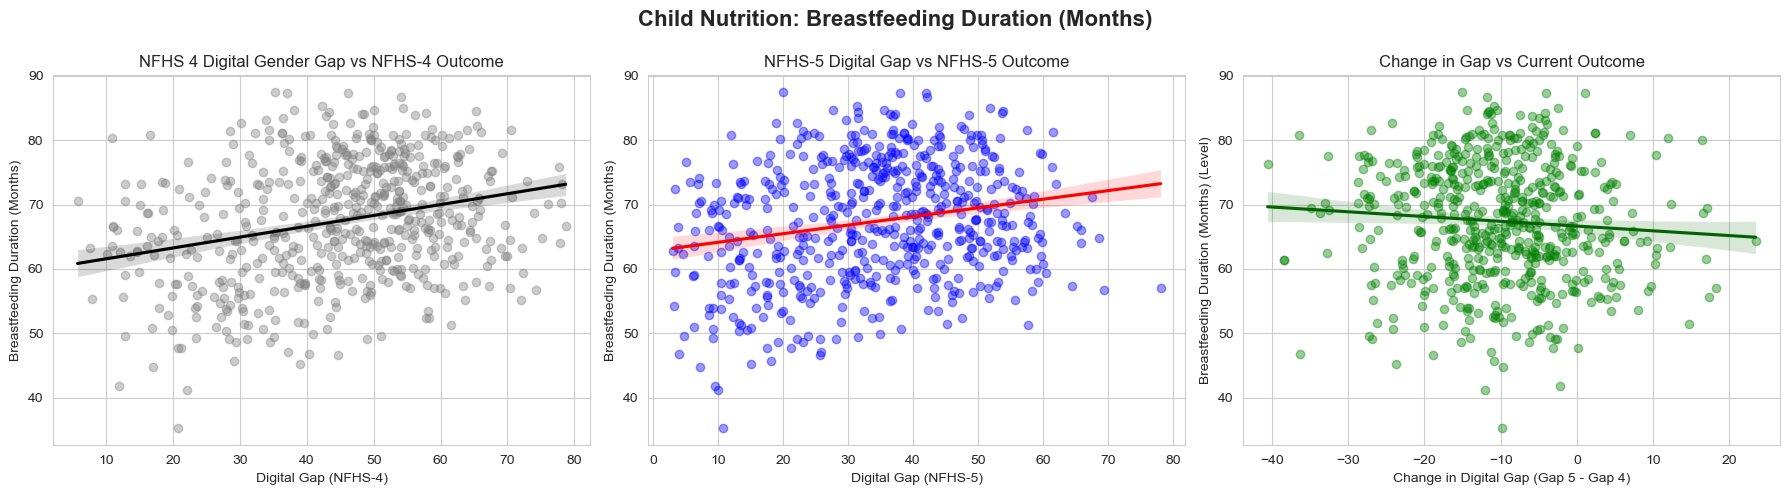


--- Processing Domestic Violence ---
Plotting: Ever Slapped (%)


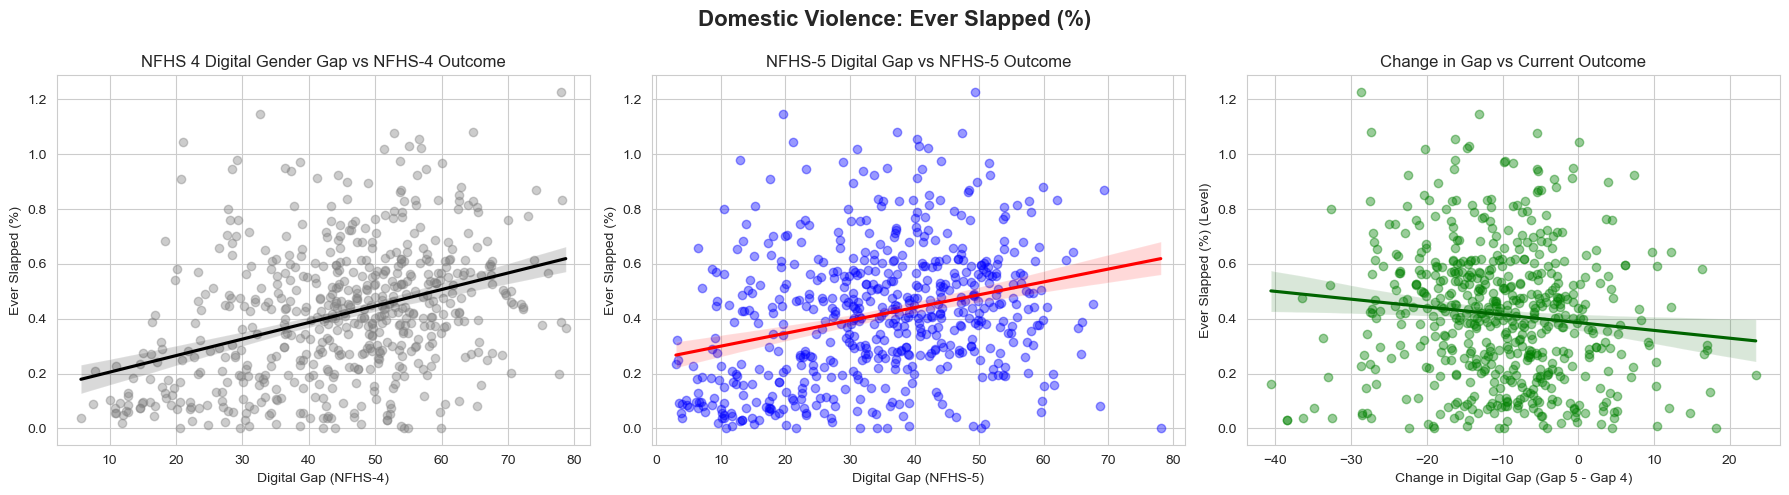

Plotting: Ever Hit (%)


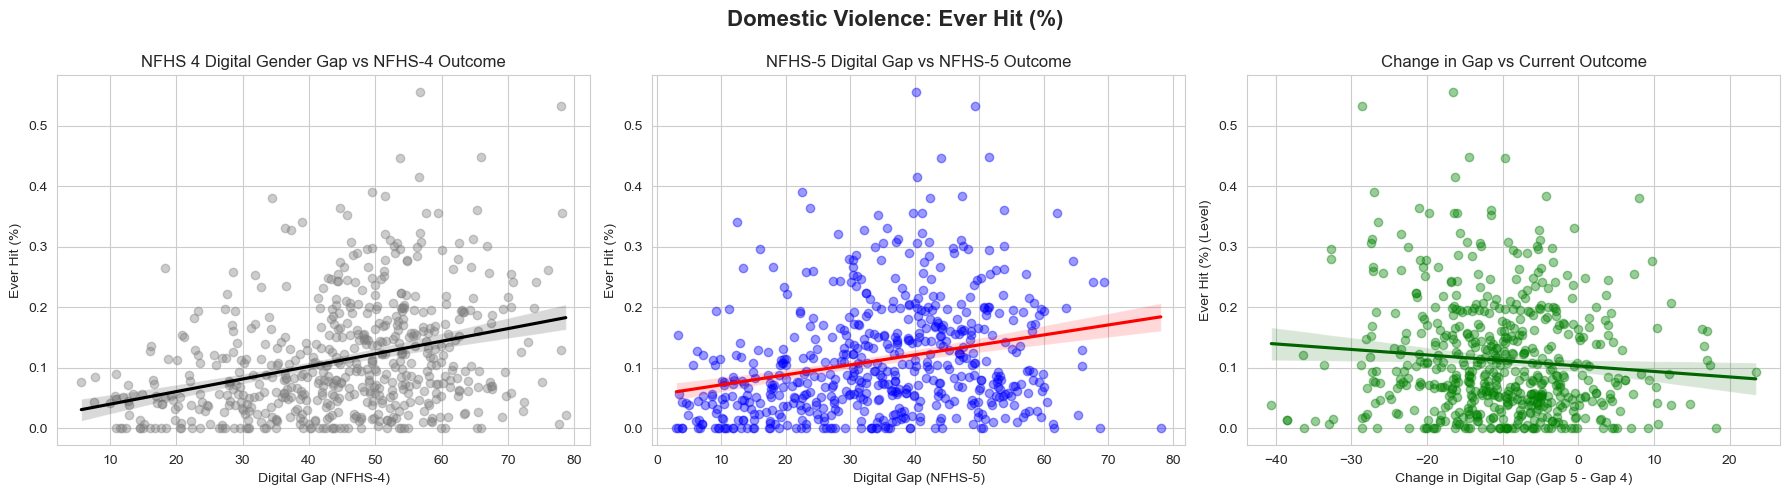

Plotting: Sexual Violence (%)


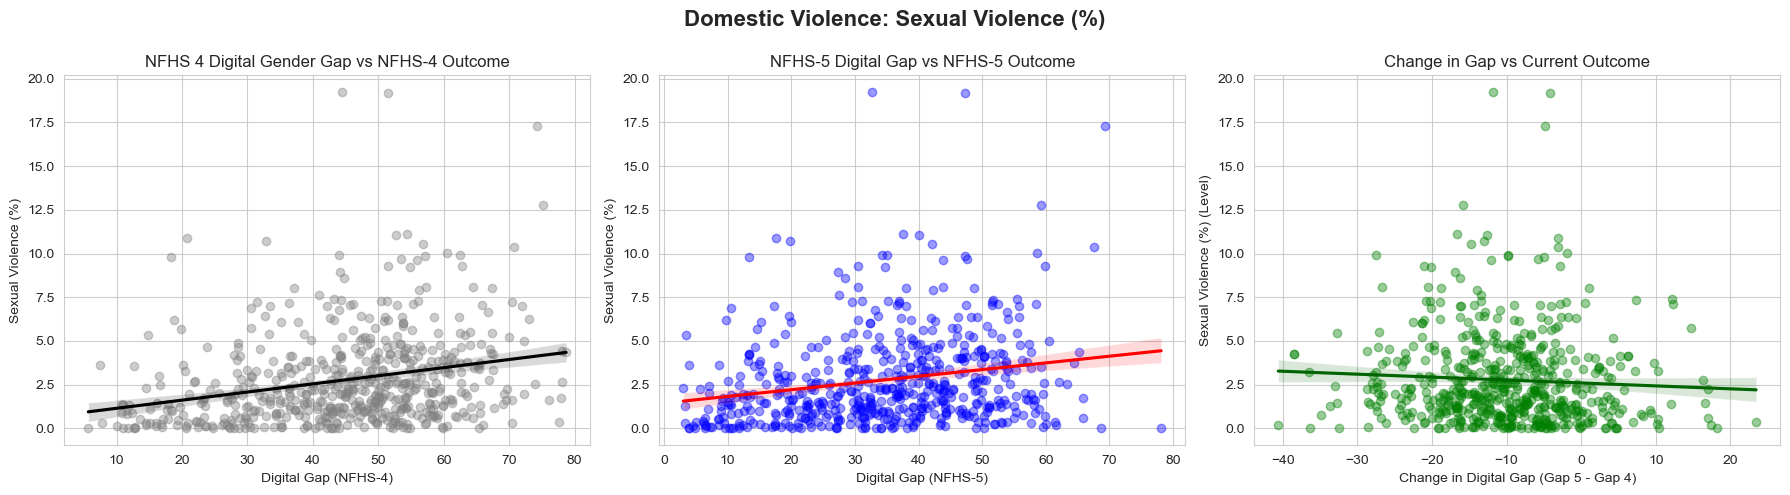


--- Generating KDE Plot for Change in Digital Gap ---


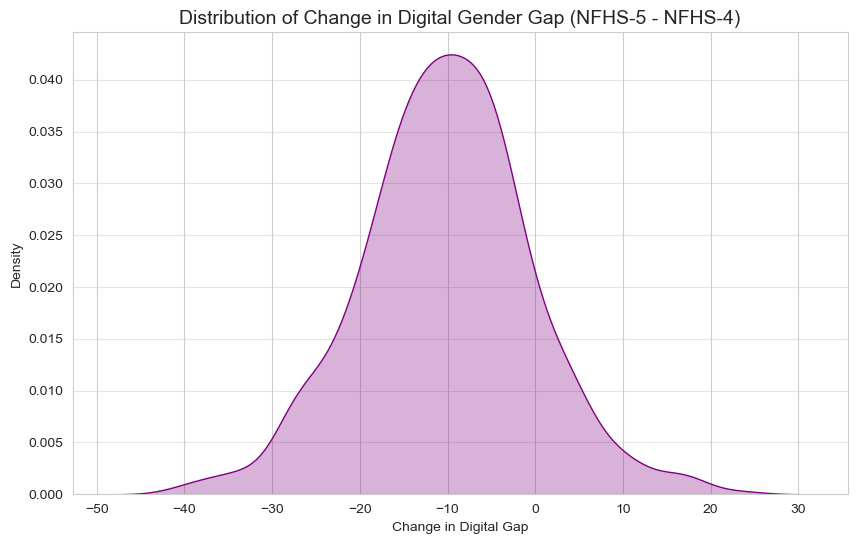

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def run_comprehensive_plotting():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Prepare Digital Gap Variables
    # NFHS-5 Gap
    gap_5 = 'dd_mobile_own_5'
    
    # NFHS-4 Gap
    gap_4 = 'dd_mobile_own_4'
    
    # Change in Gap
    change_gap = 'change_in_digital_gap'
    if change_gap not in df.columns:
        if gap_5 in df.columns and gap_4 in df.columns:
            df[change_gap] = df[gap_5] - df[gap_4]
        else:
            print("Error: Digital Gap columns (4 and 5) missing. Cannot calculate change.")
            return

    # 3. Define Outcome Categories
    outcomes = {
        'Child Nutrition': {
            'Breastfeeding Percentage (%)': 'f_pct_ever_breastfed_c1', 
            'Breastfeeding Duration (Months)': 'f_mean_bf_dur_c1'      
        },
        'Domestic Violence': {
            'Ever Slapped (%)': 'm_slapped',
            'Ever Hit (%)': 'm_punched_hit_harmful',
            'Sexual Violence (%)': 'm_experienced_any_sexual_viol'
        }
    }

    sns.set_style("whitegrid")

    # 4. Helper Function for Plotting
    def plot_row(category_name, var_label, col_current):
        """
        Plots 3 graphs per outcome variable.
        """
        col_old = None
        potential_suffixes = ['_4', '_nfhs4', '_old']
        for suffix in potential_suffixes:
            check_col = col_current + suffix
            if check_col in df.columns:
                col_old = check_col
                break
                
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'{category_name}: {var_label}', fontsize=16, weight='bold')

        # --- Plot 1: Old Regression (NFHS-4) ---
        if gap_4 in df.columns:
            x_var = gap_4
            if col_old:
                y_var = col_old
                title = "NFHS 4 Digital Gender Gap vs NFHS-4 Outcome"
                color = 'gray'
            else:
                y_var = col_current
                title = "NFHS 4 Digital Gender Gap vs NFHS-4 Outcome"
                color = 'gray'
            
            subset = df[[x_var, y_var]].dropna()
            if not subset.empty:
                sns.regplot(ax=axes[0], x=x_var, y=y_var, data=subset,
                            scatter_kws={'alpha':0.4, 'color':color}, line_kws={'color':'black'})
                axes[0].set_title(title)
                axes[0].set_xlabel("Digital Gap (NFHS-4)")
                axes[0].set_ylabel(var_label)
            else:
                axes[0].text(0.5, 0.5, "No Data", ha='center')

        # --- Plot 2: New Regression (NFHS-5) ---
        if gap_5 in df.columns:
            subset = df[[gap_5, col_current]].dropna()
            if not subset.empty:
                sns.regplot(ax=axes[1], x=gap_5, y=col_current, data=subset,
                            scatter_kws={'alpha':0.4, 'color':'blue'}, line_kws={'color':'red'})
                axes[1].set_title("NFHS-5 Digital Gap vs NFHS-5 Outcome")
                axes[1].set_xlabel("Digital Gap (NFHS-5)")
                axes[1].set_ylabel(var_label)

        # --- Plot 3: Change Analysis ---
        x_var = change_gap
        
        if col_old:
            change_col_out = f'change_{col_current}'
            df[change_col_out] = df[col_current] - df[col_old]
            y_var = change_col_out
            title = "Change in Gap vs Change in Outcome"
            ylabel = f"Change in {var_label}"
            color = 'green'
        else:
            y_var = col_current
            title = "Change in Gap vs Current Outcome"
            ylabel = f"{var_label} (Level)"
            color = 'green'

        subset = df[[x_var, y_var]].dropna()
        if not subset.empty:
            sns.regplot(ax=axes[2], x=x_var, y=y_var, data=subset,
                        scatter_kws={'alpha':0.4, 'color':color}, line_kws={'color':'darkgreen'})
            axes[2].set_title(title)
            axes[2].set_xlabel("Change in Digital Gap (Gap 5 - Gap 4)")
            axes[2].set_ylabel(ylabel)

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

    # 5. Execute Loop
    print("Generating Plots...")
    
    for cat, vars_dict in outcomes.items():
        print(f"\n--- Processing {cat} ---")
        for label, col in vars_dict.items():
            if col in df.columns:
                print(f"Plotting: {label}")
                plot_row(cat, label, col)
            else:
                print(f"Warning: Column '{col}' for {label} not found in CSV.")

    # 6. NEW: KDE Plot for Change in Digital Gender Gap
    print("\n--- Generating KDE Plot for Change in Digital Gap ---")
    if change_gap in df.columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df, x=change_gap, fill=True, color='purple', alpha=0.3)
        plt.title('Distribution of Change in Digital Gender Gap (NFHS-5 - NFHS-4)', fontsize=14)
        plt.xlabel('Change in Digital Gap')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.5)
        plt.show()
    else:
        print("Cannot plot KDE: Change in Digital Gap column missing.")

if __name__ == "__main__":
    run_comprehensive_plotting()

In [5]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

def run_regression_table():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Prepare Variables
    gap_5 = 'dd_mobile_own_5'
    gap_4 = 'dd_mobile_own_4'
    change_gap = 'change_in_digital_gap'

    # Calculate change if it doesn't exist in the CSV
    if change_gap not in df.columns:
        if gap_5 in df.columns and gap_4 in df.columns:
            df[change_gap] = df[gap_5] - df[gap_4]
        else:
            print("Error: Digital Gap columns missing. Cannot run regression.")
            return

    # 3. Define Outcomes 
    # (Flattened dictionary mapping Display Name -> Column Name)
    outcome_vars = {
        'Breastfeeding (%)': 'f_pct_ever_breastfed_c1', 
        'BF Duration': 'f_mean_bf_dur_c1',
        'Ever Slapped': 'm_slapped',
        'Ever Hit': 'm_punched_hit_harmful',
        'Sexual Violence': 'm_experienced_any_sexual_viol'
    }

    # 4. Run Regressions
    models = []
    model_names = []

    print("Running OLS Regressions...")
    
    for name, col in outcome_vars.items():
        if col in df.columns:
            # Drop missing values for this specific pair to avoid errors
            subset = df[[change_gap, col]].dropna()
            
            if not subset.empty:
                # Define Formula: Outcome = Intercept + Beta * Change_in_Gap
                formula = f"{col} ~ {change_gap}"
                
                # Fit the model
                model = smf.ols(formula, data=subset).fit()
                
                models.append(model)
                model_names.append(name)
            else:
                print(f"Skipping {name}: No valid data points (all NaNs).")
        else:
            print(f"Skipping {name}: Column {col} not found in CSV.")

    # 5. Create and Print the Table
    if models:
        # summary_col combines multiple model results into one table
        results_table = summary_col(
            models,
            model_names=model_names,
            stars=True,             # Adds *** for significance
            float_format='%0.4f',   # 4 decimal places
            regressor_order=[change_gap, 'Intercept'],
            info_dict={
                'N': lambda x: f"{int(x.nobs)}",
                'R2': lambda x: f"{x.rsquared:.3f}"
            }
        )

        print("\n" + "="*90)
        print("REGRESSION TABLE: Impact of Change in Digital Gender Gap")
        print("="*90)
        print(results_table)
        print("="*90)
        print("Legend: * p<0.1; ** p<0.05; *** p<0.01")
        
        # Optional: Save table to a text file
        # with open('regression_results.txt', 'w') as f:
        #     f.write(results_table.as_text())
            
    else:
        print("No regression models could be generated.")

if __name__ == "__main__":
    run_regression_table()

Running OLS Regressions...

REGRESSION TABLE: Impact of Change in Digital Gender Gap

                      Breastfeeding (%) BF Duration Ever Slapped  Ever Hit Sexual Violence
------------------------------------------------------------------------------------------
change_in_digital_gap 0.0730            -0.0740*    -0.0028***   -0.0009** -0.0167        
                      (0.0487)          (0.0401)    (0.0010)     (0.0004)  (0.0113)       
Intercept             34.9977***        66.6671***  0.3862***    0.1033*** 2.6016***      
                      (0.6842)          (0.5635)    (0.0147)     (0.0057)  (0.1591)       
R-squared             0.0039            0.0059      0.0128       0.0087    0.0038         
R-squared Adj.        0.0022            0.0042      0.0111       0.0070    0.0021         
N                     574               574         574          574       574            
R2                    0.004             0.006       0.013        0.009     0.004          
Stan

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

def run_exact_plotting_regressions():
    # 1. Load Data
    try:
        df = pd.read_csv('ultimate.csv')
    except FileNotFoundError:
        print("Error: ultimate.csv not found.")
        return

    # 2. Prepare Predictors (The exact X variables from plotting)
    gap_5 = 'dd_mobile_own_5'
    gap_4 = 'dd_mobile_own_4'
    change_gap = 'change_in_digital_gap'

    # Calculate change if missing
    if change_gap not in df.columns:
        if gap_5 in df.columns and gap_4 in df.columns:
            df[change_gap] = df[gap_5] - df[gap_4]
        else:
            print("Error: Digital Gap columns missing.")
            return

    # 3. Define Outcomes (Exact dict from plotting)
    outcomes = {
        'Breastfeeding (%)': 'f_pct_ever_breastfed_c1', 
        'BF Duration': 'f_mean_bf_dur_c1',
        'Ever Slapped': 'm_slapped',
        'Ever Hit': 'm_punched_hit_harmful',
        'Sexual Violence': 'm_experienced_any_sexual_viol'
    }

    print("Generating Regression Tables based on Plotting Logic...\n")

    # 4. Loop through each outcome
    for label, col_current in outcomes.items():
        if col_current not in df.columns:
            print(f"Skipping {label}: Column missing.")
            continue

        models = []
        model_names = []

        # --- LOGIC MIRRORING YOUR PLOT_ROW FUNCTION ---
        
        # Check for Old Column (Just like in your plot function)
        col_old = None
        potential_suffixes = ['_4', '_nfhs4', '_old']
        for suffix in potential_suffixes:
            check_col = col_current + suffix
            if check_col in df.columns:
                col_old = check_col
                break

        # --- Model 1: Corresponds to Plot 1 (Gap 4) ---
        # If old col exists, use it. If not, use current col (Proxy).
        y_var_1 = col_old if col_old else col_current
        subset_1 = df[[y_var_1, gap_4]].dropna()
        
        if not subset_1.empty:
            formula1 = f"{y_var_1} ~ {gap_4}"
            m1 = smf.ols(formula1, data=subset_1).fit()
            models.append(m1)
            model_names.append("NFHS-4 Gap")

        # --- Model 2: Corresponds to Plot 2 (Gap 5) ---
        # Always uses Current Outcome vs Gap 5
        subset_2 = df[[col_current, gap_5]].dropna()
        if not subset_2.empty:
            formula2 = f"{col_current} ~ {gap_5}"
            m2 = smf.ols(formula2, data=subset_2).fit()
            models.append(m2)
            model_names.append("NFHS-5 Gap")

        # --- Model 3: Corresponds to Plot 3 (Change) ---
        # If old col exists, use Change in Outcome. If not, use Current Outcome.
        x_var_3 = change_gap
        
        if col_old:
            # Calculate change manually like in plotting
            y_var_3 = f'change_{col_current}'
            df[y_var_3] = df[col_current] - df[col_old]
        else:
            y_var_3 = col_current

        subset_3 = df[[y_var_3, x_var_3]].dropna()
        if not subset_3.empty:
            formula3 = f"{y_var_3} ~ {x_var_3}"
            m3 = smf.ols(formula3, data=subset_3).fit()
            models.append(m3)
            model_names.append("Change in Gap")

        # --- Generate Table for this Outcome ---
        if models:
            info_dict = {
                'N': lambda x: f"{int(x.nobs)}",
                'R2': lambda x: f"{x.rsquared:.3f}",
                'Mean Dep. Var': lambda x: f"{x.model.endog.mean():.2f}"
            }
            
            table = summary_col(
                models,
                model_names=model_names,
                stars=True,
                float_format='%0.4f',
                regressor_order=[gap_4, gap_5, change_gap, 'Intercept'],
                info_dict=info_dict
            )
            
            print("="*80)
            print(f"OUTCOME: {label}")
            print("="*80)
            print(table)
            print("\n")

if __name__ == "__main__":
    run_exact_plotting_regressions()

Generating Regression Tables based on Plotting Logic...

OUTCOME: Breastfeeding (%)

                      NFHS-4 Gap NFHS-5 Gap Change in Gap
---------------------------------------------------------
dd_mobile_own_4       -0.2248***                         
                      (0.0304)                           
dd_mobile_own_5                  -0.1891***              
                                 (0.0305)                
change_in_digital_gap                       0.0730       
                                            (0.0487)     
Intercept             44.2917*** 40.7840*** 34.9977***   
                      (1.4338)   (1.1466)   (0.6842)     
R-squared             0.0869     0.0631     0.0039       
R-squared Adj.        0.0853     0.0615     0.0022       
Mean Dep. Var         34.24      34.25      34.25        
N                     575        574        574          
R2                    0.087      0.063      0.004        
Standard errors in parentheses.
* p<.1, ** p<

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Load the dataset
df = pd.read_csv('ultimate.csv')

# Quick inspection of relevant columns for the Digital Divide
# 'urban_share_5' appears to be the Census 2011 urban share or similar.
# 'f_pct_has_mobile' and 'm_pct_owns_mobile' represent digital access.
# We will use the relationship between Urban Share and Digital Access to proxy the "Urban-Rural Digital Divide".
# Alternatively, if 'dd_gap' represents a pre-calculated divide, you can substitute it.

print(df[['district', 'urban_share_5', 'f_pct_has_mobile', 'm_pct_owns_mobile']].head())

     district  urban_share_5  f_pct_has_mobile  m_pct_owns_mobile
0    adilabad      25.976451         40.360081          90.498764
1  agar malwa      20.293273         22.350174          92.735023
2        agra      60.689737         39.867786          86.977249
3   ahmadabad      82.397508         71.727058          98.176697
4  ahmadnagar      22.311863         44.230579          95.963005


Correlation between Urban Share and Female Mobile Ownership: 0.38


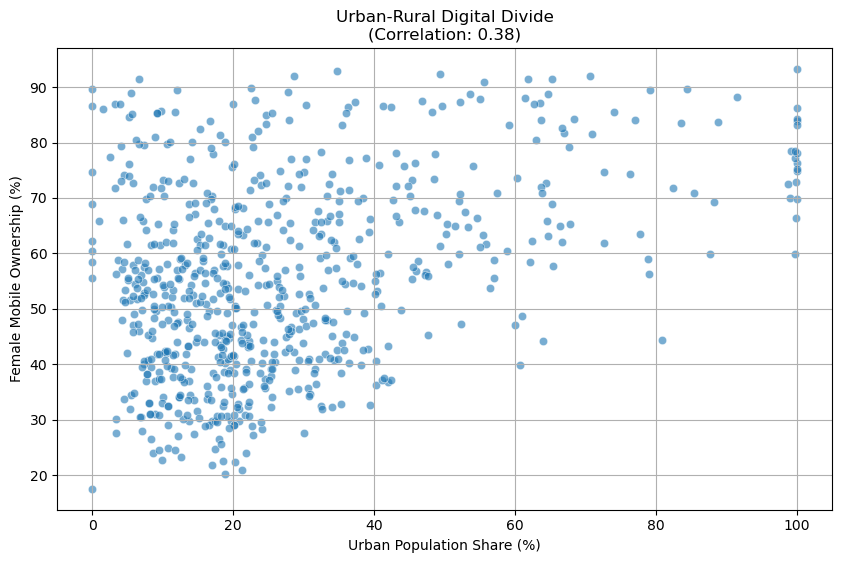

In [4]:
# Calculate correlation
corr = df['urban_share_5'].corr(df['f_pct_has_mobile'])
print(f"Correlation between Urban Share and Female Mobile Ownership: {corr:.2f}")

# Visualizing the Urban-Rural Digital Divide
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='urban_share_5', y='f_pct_has_mobile', alpha=0.6)
plt.title(f'Urban-Rural Digital Divide\n(Correlation: {corr:.2f})')
plt.xlabel('Urban Population Share (%)')
plt.ylabel('Female Mobile Ownership (%)')
plt.grid(True)
plt.show()

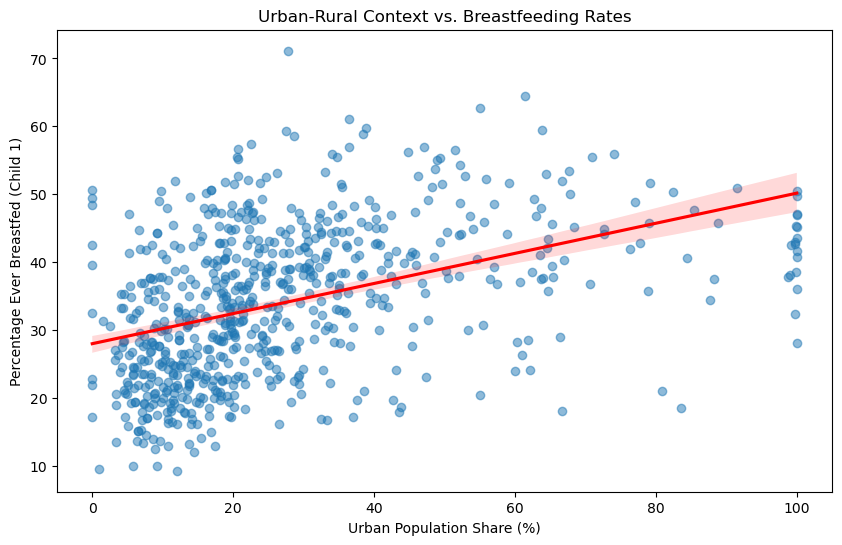

Correlation between Urban Share and Breastfeeding: 0.43


In [5]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='urban_share_5', y='f_pct_ever_breastfed_c1', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Urban-Rural Context vs. Breastfeeding Rates')
plt.xlabel('Urban Population Share (%)')
plt.ylabel('Percentage Ever Breastfed (Child 1)')
plt.show()

# Correlation
bf_corr = df['urban_share_5'].corr(df['f_pct_ever_breastfed_c1'])
print(f"Correlation between Urban Share and Breastfeeding: {bf_corr:.2f}")

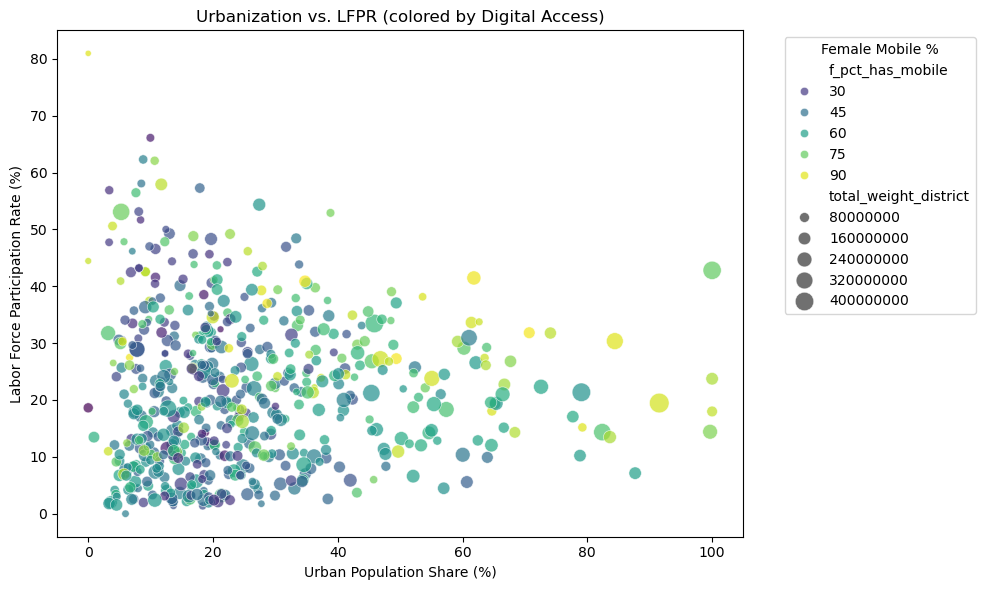

Correlation between Urban Share and LFPR: -0.00


In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='urban_share_5', y='lfpr_percent', hue='f_pct_has_mobile', palette='viridis', size='total_weight_district', sizes=(20, 200), alpha=0.7)
plt.title('Urbanization vs. LFPR (colored by Digital Access)')
plt.xlabel('Urban Population Share (%)')
plt.ylabel('Labor Force Participation Rate (%)')
plt.legend(title='Female Mobile %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Simple correlation
lfpr_corr = df['urban_share_5'].corr(df['lfpr_percent'])
print(f"Correlation between Urban Share and LFPR: {lfpr_corr:.2f}")

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\mnt\\data\\regression_table.png'

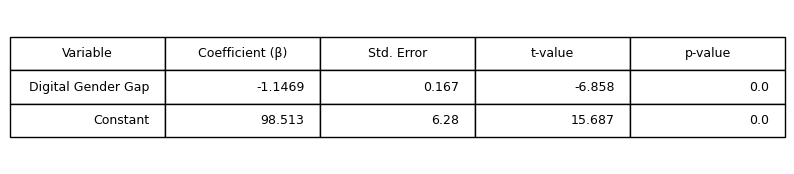

In [1]:
import matplotlib.pyplot as plt

# Data
data = [
    ["Digital Gender Gap", -1.1469, 0.167, -6.858, 0.000],
    ["Constant", 98.5130, 6.280, 15.687, 0.000],
]

columns = ["Variable", "Coefficient (β)", "Std. Error", "t-value", "p-value"]

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

table = ax.table(cellText=data, colLabels=columns, loc='center')
table.scale(1, 2)

plt.savefig('/mnt/data/regression_table.png', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# ---------------------------------------------------------
# 1. Prepare Data
# ---------------------------------------------------------
# Assuming 'df' is your existing dataframe.
# If you are running this as a standalone test, uncomment the lines below to generate dummy data.

# np.random.seed(42)
# n = 100
# # Generate dummy control data (Stagnant)
# control_data = np.random.normal(55, 15, n)
# control_data = np.clip(control_data, 0, 100)
# # Generate dummy treated data (Rapidly Closing)
# treated_data = np.random.normal(65, 15, n)
# treated_data = np.clip(treated_data, 10, 110)
#
# df = pd.DataFrame({
#     'treatment_status': ['Stagnant / Worsening\n(Control)'] * n + ['Rapidly Closing Gap\n(Treated)'] * n,
#     'lfpr_percent': np.concatenate([control_data, treated_data])
# })

# ---------------------------------------------------------
# 2. Plot Configuration
# ---------------------------------------------------------
# Set the visual style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Define colors matching your image
colors = {
    'box_control': '#F4CCCC',    # Light Red/Pink
    'box_treated': '#D9EAD3',    # Light Green
    'points_control': '#CC4125', # Darker Red
    'points_treated': '#6AA84F'  # Darker Green
}

# ---------------------------------------------------------
# 3. Create the Plot
# ---------------------------------------------------------

# Define the order of categories on the X-axis
order = ['Stagnant / Worsening\n(Control)', 'Rapidly Closing Gap\n(Treated)']

# A. Create the Boxplot (The background boxes)
# showfliers=False hides the default outliers so we can draw our own points over them
ax = sns.boxplot(
    x='treatment_status',
    y='lfpr_percent',
    data=df,
    order=order,
    palette=[colors['box_control'], colors['box_treated']],
    width=0.5,
    showfliers=False,
    linewidth=1.5
)

# B. Create the Stripplot (The individual dots)
# jitter=True spreads them out horizontally
sns.stripplot(
    x='treatment_status',
    y='lfpr_percent',
    data=df,
    order=order,
    palette=[colors['points_control'], colors['points_treated']],
    size=6,
    jitter=0.25,
    alpha=0.7,
    edgecolor='gray',  # Optional: adds a slight border to dots for clarity
    linewidth=0.5,
    ax=ax
)

# C. Add Mean Markers (The Black Diamonds)
# Calculate means for each group
means = df.groupby('treatment_status')['lfpr_percent'].mean()

# Extract means in the correct order
mean_values = [means[cat] for cat in order]

# Plot the diamonds
plt.scatter(
    x=[0, 1], # 0 is the first category, 1 is the second
    y=mean_values,
    marker='D',
    color='black',
    s=60, # Size of the diamond
    zorder=10, # Ensure it sits on top of everything
    label='Mean'
)

# ---------------------------------------------------------
# 4. Final Formatting
# ---------------------------------------------------------

# Titles and Labels
plt.title("Women's LFPR: Individual District Performance", fontsize=14, pad=15)
plt.ylabel("Labor Force Participation Rate (2019)", fontsize=12)
plt.xlabel("Group", fontsize=12)

# Remove the top and right spines for a cleaner look (optional, matches many publication styles)
sns.despine(trim=True)

# Custom Legend
# We reconstruct the legend manually to match the specific style
legend_elements = [
    Line2D([0], [0], color=colors['box_control'], lw=6, label='Stagnant / Worsening\n(Control)'),
    Line2D([0], [0], color=colors['box_treated'], lw=6, label='Rapidly Closing Gap\n(Treated)'),
    Line2D([0], [0], marker='D', color='w', label='Group Mean', markerfacecolor='black', markersize=8)
]

plt.legend(
    handles=legend_elements,
    title='Group',
    loc='lower right',
    bbox_to_anchor=(0.95, 0.05),
    frameon=True,
    facecolor='white',
    framealpha=0.9
)

# Adjust layout and show
plt.tight_layout()
plt.show()

C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_1440\2667071687.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

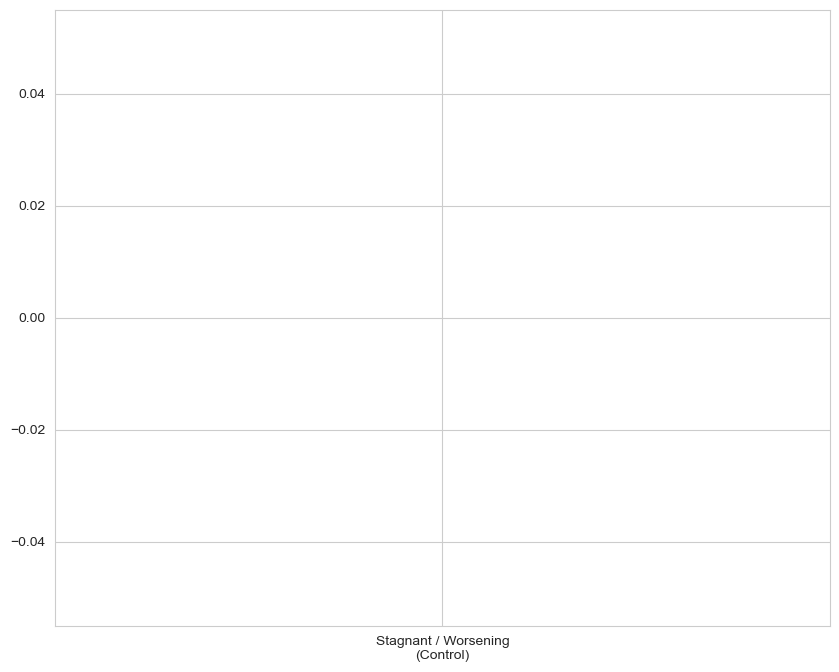

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# ---------------------------------------------------------
# 1. Prepare Data
# ---------------------------------------------------------
df = pd.read_csv('ultimate.csv')

# ---------------------------------------------------------
# 2. Plot Configuration
# ---------------------------------------------------------
# Set the visual style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Define colors matching your image
colors = {
    'box_control': '#F4CCCC',    # Light Red/Pink
    'box_treated': '#D9EAD3',    # Light Green
    'points_control': '#CC4125', # Darker Red
    'points_treated': '#6AA84F'  # Darker Green
}

# ---------------------------------------------------------
# 3. Create the Plot
# ---------------------------------------------------------

# Define the order of categories on the X-axis
# NOTE: Ensure the strings inside 'treatment_status' in your CSV match these exactly.
# If your CSV uses different labels, update this list.
order = ['Stagnant / Worsening\n(Control)', 'Rapidly Closing Gap\n(Treated)']

# A. Create the Boxplot (The background boxes)
# showfliers=False hides the default outliers so we can draw our own points over them
ax = sns.boxplot(
    x='treatment_status',
    y='lfpr_percent',
    data=df,
    order=order,
    palette=[colors['box_control'], colors['box_treated']],
    width=0.5,
    showfliers=False,
    linewidth=1.5
)

# B. Create the Stripplot (The individual dots)
# jitter=True spreads them out horizontally
sns.stripplot(
    x='treatment_status',
    y='lfpr_percent',
    data=df,
    order=order,
    palette=[colors['points_control'], colors['points_treated']],
    size=6,
    jitter=0.25,
    alpha=0.7,
    edgecolor='gray',  # Optional: adds a slight border to dots for clarity
    linewidth=0.5,
    ax=ax
)

# C. Add Mean Markers (The Black Diamonds)
# Calculate means for each group
means = df.groupby('treatment_status')['lfpr_percent'].mean()

# Extract means in the correct order
# Use .get() to handle cases where a category might be missing in the data
mean_values = [means.get(cat, np.nan) for cat in order]

# Plot the diamonds
plt.scatter(
    x=[0, 1], # 0 is the first category, 1 is the second
    y=mean_values,
    marker='D',
    color='black',
    s=60, # Size of the diamond
    zorder=10, # Ensure it sits on top of everything
    label='Mean'
)

# ---------------------------------------------------------
# 4. Final Formatting
# ---------------------------------------------------------

# Titles and Labels
plt.title("Women's LFPR: Individual District Performance", fontsize=14, pad=15)
plt.ylabel("Labor Force Participation Rate (2019)", fontsize=12)
plt.xlabel("Group", fontsize=12)

# Remove the top and right spines for a cleaner look (optional, matches many publication styles)
sns.despine(trim=True)

# Custom Legend
# We reconstruct the legend manually to match the specific style
legend_elements = [
    Line2D([0], [0], color=colors['box_control'], lw=6, label='Stagnant / Worsening\n(Control)'),
    Line2D([0], [0], color=colors['box_treated'], lw=6, label='Rapidly Closing Gap\n(Treated)'),
    Line2D([0], [0], marker='D', color='w', label='Group Mean', markerfacecolor='black', markersize=8)
]

plt.legend(
    handles=legend_elements,
    title='Group',
    loc='lower right',
    bbox_to_anchor=(0.95, 0.05),
    frameon=True,
    facecolor='white',
    framealpha=0.9
)

# Adjust layout and show
plt.tight_layout()
plt.show()

CRITICAL ERROR: Could not find 'Stagnant' or 'Rapidly' in the CSV data.
Found values: ['non treated' 'treated']


ValueError: List of boxplot statistics and `positions` values must have same the length

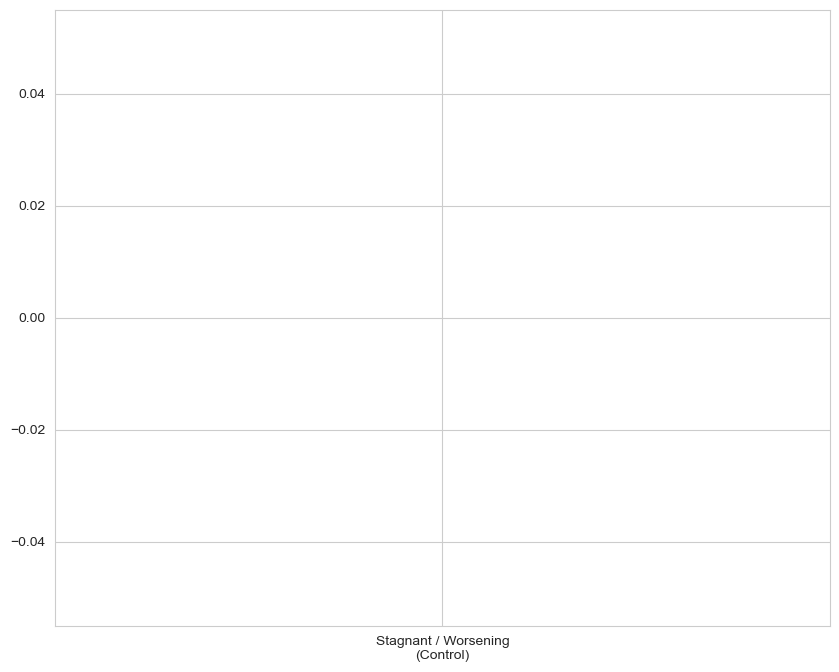

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D

# ---------------------------------------------------------
# 1. Prepare Data & Fix Category Names
# ---------------------------------------------------------
df = pd.read_csv('ultimate.csv')

# Convert to string to avoid type errors
df['treatment_status'] = df['treatment_status'].astype(str)

# Define our Desired Standard Labels (with newlines for the plot)
label_control = 'Stagnant / Worsening\n(Control)'
label_treated = 'Rapidly Closing Gap\n(Treated)'

# Create a robust mapping dictionary based on keywords
# This fixes issues where the CSV might miss the '\n' or have different spacing
status_map = {}
for val in df['treatment_status'].unique():
    if "Stagnant" in val:
        status_map[val] = label_control
    elif "Rapidly" in val:
        status_map[val] = label_treated
    else:
        status_map[val] = val # Keep others as is

# Apply the mapping
df['treatment_status_plot'] = df['treatment_status'].map(status_map)

# Define the strict order for plotting
order = [label_control, label_treated]

# Check if data exists after mapping
data_check = df[df['treatment_status_plot'].isin(order)]
if data_check.empty:
    print("CRITICAL ERROR: Could not find 'Stagnant' or 'Rapidly' in the CSV data.")
    print(f"Found values: {df['treatment_status'].unique()}")
else:
    print("Data found and mapped successfully.")

# ---------------------------------------------------------
# 2. Plot Configuration
# ---------------------------------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

colors = {
    'box_control': '#F4CCCC',    # Light Red/Pink
    'box_treated': '#D9EAD3',    # Light Green
    'points_control': '#CC4125', # Darker Red
    'points_treated': '#6AA84F'  # Darker Green
}

# ---------------------------------------------------------
# 3. Create the Plot
# ---------------------------------------------------------

# A. Create the Boxplot
# Note: We use 'treatment_status_plot' (the mapped column)
ax = sns.boxplot(
    x='treatment_status_plot',
    y='lfpr_percent',
    data=df,
    order=order,
    width=0.5,
    showfliers=False,
    linewidth=1.5
    # REMOVED palette/hue to prevent Seaborn UnboundLocalError/ValueError
)

# B. Manually Color the Boxes
# This is the safest way to color boxes without triggering version-specific Seaborn bugs
box_palette = [colors['box_control'], colors['box_treated']]
boxes = [p for p in ax.patches if isinstance(p, PathPatch)]

# Fallback for older matplotlib versions where boxes are artists
if not boxes:
    boxes = ax.artists

# Apply colors
for i, box in enumerate(boxes):
    if i < len(box_palette):
        box.set_facecolor(box_palette[i])

# C. Create the Stripplot
sns.stripplot(
    x='treatment_status_plot',
    y='lfpr_percent',
    data=df,
    order=order,
    palette=[colors['points_control'], colors['points_treated']],
    size=6,
    jitter=0.25,
    alpha=0.7,
    edgecolor='gray',
    linewidth=0.5,
    ax=ax,
    legend=False
)

# D. Add Mean Markers
means = df.groupby('treatment_status_plot')['lfpr_percent'].mean()
mean_values = [means.get(cat, np.nan) for cat in order]

plt.scatter(
    x=[0, 1],
    y=mean_values,
    marker='D',
    color='black',
    s=60,
    zorder=10,
    label='Mean'
)

# ---------------------------------------------------------
# 4. Final Formatting
# ---------------------------------------------------------

plt.title("Women's LFPR: Individual District Performance", fontsize=14, pad=15)
plt.ylabel("Labor Force Participation Rate (2019)", fontsize=12)
plt.xlabel("Group", fontsize=12)

sns.despine(trim=True)

# Custom Legend
legend_elements = [
    Line2D([0], [0], color=colors['box_control'], lw=6, label='Stagnant / Worsening\n(Control)'),
    Line2D([0], [0], color=colors['box_treated'], lw=6, label='Rapidly Closing Gap\n(Treated)'),
    Line2D([0], [0], marker='D', color='w', label='Group Mean', markerfacecolor='black', markersize=8)
]

plt.legend(
    handles=legend_elements,
    title='Group',
    loc='lower right',
    bbox_to_anchor=(0.95, 0.05),
    frameon=True,
    facecolor='white',
    framealpha=0.9
)

plt.tight_layout()
plt.show()

Successfully read merged.csv
Unique treatment_status values found in CSV: ['non treated' 'treated']
Rows remaining after filtering: 705
Categories present in plot data: ['Rapidly Closing Gap\n(Treated)']


C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_1440\3391257914.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_1440\3391257914.py:98: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


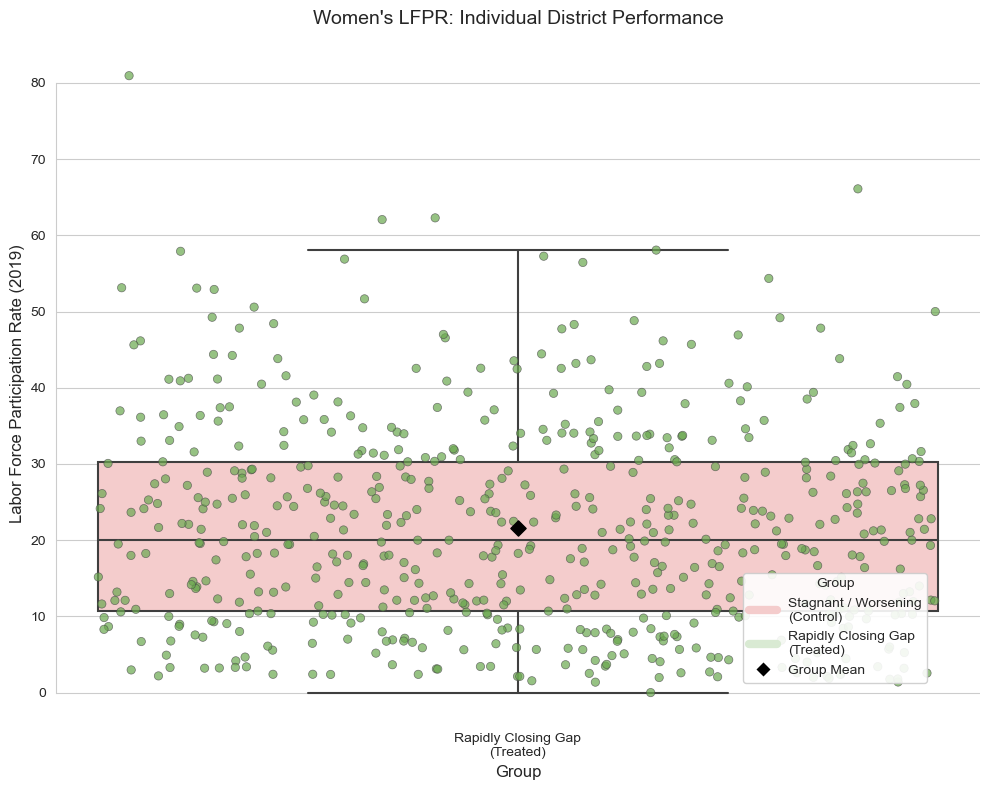

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D

# ---------------------------------------------------------
# 1. Prepare Data & Fix Category Names
# ---------------------------------------------------------
try:
    df = pd.read_csv('ultimate.csv')
    print("Successfully read merged.csv")
    print("Unique treatment_status values found in CSV:", df['treatment_status'].unique())
except Exception as e:
    print(f"Error reading CSV: {e}")
    # Initialize empty df to prevent crash if file read fails
    df = pd.DataFrame(columns=['treatment_status', 'lfpr_percent'])

# Ensure column is string and stripped of whitespace
df['treatment_status'] = df['treatment_status'].astype(str).str.strip()

# Target Labels (Standardized for the plot)
label_control = 'Stagnant / Worsening\n(Control)'
label_treated = 'Rapidly Closing Gap\n(Treated)'
order = [label_control, label_treated]

# Robust Mapping Function
def map_status(val):
    val_lower = val.lower()
    # Check for Control keywords (including '0' if data is numeric-coded)
    if 'stagnant' in val_lower or 'non-treated' in val_lower or val == '0':
        return label_control
    # Check for Treated keywords (including '1' if data is numeric-coded)
    if 'rapidly' in val_lower or 'treated' in val_lower or val == '1':
        return label_treated
    return None # Return None for anything that doesn't match

# Apply mapping
df['treatment_status_plot'] = df['treatment_status'].apply(map_status)

# FILTER: Create a clean dataframe with ONLY the valid mapped rows
# This prevents the "statistics vs positions" length mismatch error
df_plot = df.dropna(subset=['treatment_status_plot']).copy()

# Debugging Output
print(f"Rows remaining after filtering: {len(df_plot)}")
print(f"Categories present in plot data: {df_plot['treatment_status_plot'].unique()}")

if df_plot.empty:
    raise ValueError("CRITICAL ERROR: No data matched 'Control' or 'Treated' categories. Please check the print output above to see your CSV values.")

# ---------------------------------------------------------
# 2. Plot Configuration
# ---------------------------------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

colors = {
    'box_control': '#F4CCCC',    # Light Red/Pink
    'box_treated': '#D9EAD3',    # Light Green
    'points_control': '#CC4125', # Darker Red
    'points_treated': '#6AA84F'  # Darker Green
}

# ---------------------------------------------------------
# 3. Create the Plot
# ---------------------------------------------------------

# A. Create the Boxplot
# We use df_plot (the strictly filtered dataframe)
ax = sns.boxplot(
    x='treatment_status_plot',
    y='lfpr_percent',
    data=df_plot,
    order=order,
    width=0.5,
    showfliers=False,
    linewidth=1.5
    # REMOVED palette/hue to avoid bugs
)

# B. Manually Color the Boxes
# This is the safest, most compatible way to color boxes
box_palette = [colors['box_control'], colors['box_treated']]

# Get boxes - support both patch (newer matplotlib) and artist (older) access
boxes = [p for p in ax.patches if isinstance(p, PathPatch)]
if not boxes:
    boxes = ax.artists

# Color them safely
for i, box in enumerate(boxes):
    if i < len(box_palette):
        box.set_facecolor(box_palette[i])

# C. Create the Stripplot
sns.stripplot(
    x='treatment_status_plot',
    y='lfpr_percent',
    data=df_plot,
    order=order,
    palette=[colors['points_control'], colors['points_treated']],
    size=6,
    jitter=0.25,
    alpha=0.7,
    edgecolor='gray',
    linewidth=0.5,
    ax=ax,
    legend=False
)

# D. Add Mean Markers
means = df_plot.groupby('treatment_status_plot')['lfpr_percent'].mean()
mean_values = [means.get(cat, np.nan) for cat in order]

plt.scatter(
    x=[0, 1],
    y=mean_values,
    marker='D',
    color='black',
    s=60,
    zorder=10,
    label='Mean'
)

# ---------------------------------------------------------
# 4. Final Formatting
# ---------------------------------------------------------

plt.title("Women's LFPR: Individual District Performance", fontsize=14, pad=15)
plt.ylabel("Labor Force Participation Rate (2019)", fontsize=12)
plt.xlabel("Group", fontsize=12)

sns.despine(trim=True)

# Custom Legend
legend_elements = [
    Line2D([0], [0], color=colors['box_control'], lw=6, label='Stagnant / Worsening\n(Control)'),
    Line2D([0], [0], color=colors['box_treated'], lw=6, label='Rapidly Closing Gap\n(Treated)'),
    Line2D([0], [0], marker='D', color='w', label='Group Mean', markerfacecolor='black', markersize=8)
]

plt.legend(
    handles=legend_elements,
    title='Group',
    loc='lower right',
    bbox_to_anchor=(0.95, 0.05),
    frameon=True,
    facecolor='white',
    framealpha=0.9
)

plt.tight_layout()
plt.show()

Successfully read merged.csv


C:\Users\Soumya Pandey\AppData\Local\Temp\ipykernel_1440\1675270500.py:73: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


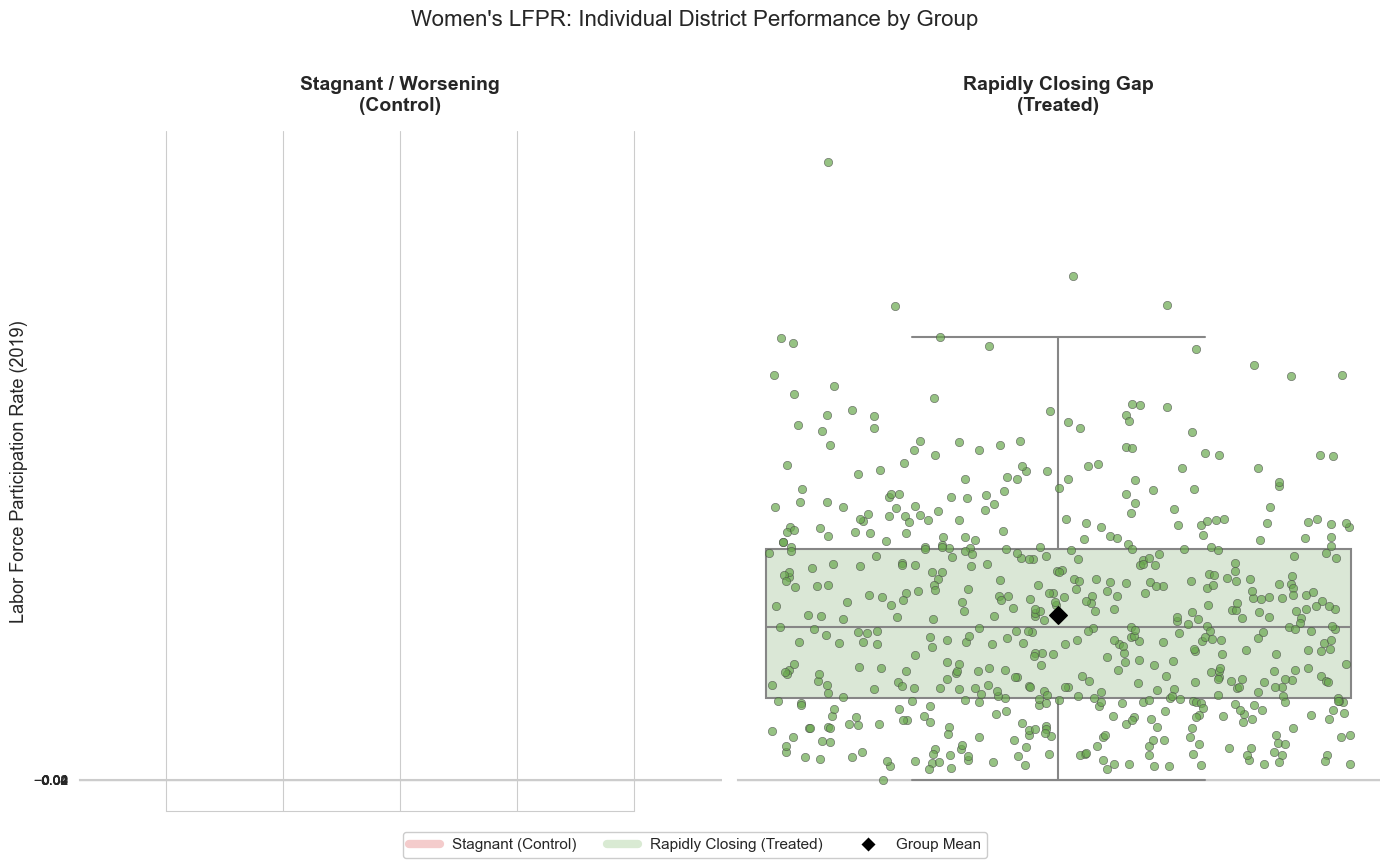

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D

# ---------------------------------------------------------
# 1. Prepare Data & Fix Category Names
# ---------------------------------------------------------
try:
    df = pd.read_csv('ultimate.csv')
    print("Successfully read merged.csv")
except Exception as e:
    print(f"Error reading CSV: {e}")
    df = pd.DataFrame(columns=['treatment_status', 'lfpr_percent'])

# Ensure column is string and stripped of whitespace
df['treatment_status'] = df['treatment_status'].astype(str).str.strip()

# Target Labels
label_control = 'Stagnant / Worsening\n(Control)'
label_treated = 'Rapidly Closing Gap\n(Treated)'

# Robust Mapping Function
def map_status(val):
    val_lower = val.lower()
    if 'stagnant' in val_lower or 'non-treated' in val_lower or val == '0':
        return label_control
    if 'rapidly' in val_lower or 'treated' in val_lower or val == '1':
        return label_treated
    return None

# Apply mapping
df['treatment_status_plot'] = df['treatment_status'].apply(map_status)
df_plot = df.dropna(subset=['treatment_status_plot']).copy()

if df_plot.empty:
    raise ValueError("CRITICAL ERROR: No data matched categories.")

# ---------------------------------------------------------
# 2. Plot Configuration
# ---------------------------------------------------------
sns.set_style("whitegrid")

# Create two separate subplots sharing the same Y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

colors = {
    'box_control': '#F4CCCC',    # Light Red/Pink
    'box_treated': '#D9EAD3',    # Light Green
    'points_control': '#CC4125', # Darker Red
    'points_treated': '#6AA84F'  # Darker Green
}

# Helper function to draw plot on specific axis
def draw_panel(ax, group_label, box_color, point_color, title):
    # Filter data for this group
    subset = df_plot[df_plot['treatment_status_plot'] == group_label]
    
    # 1. Boxplot
    sns.boxplot(
        y='lfpr_percent',
        data=subset,
        color=box_color, # Set color directly here since we have 1 box per plot
        width=0.4,
        showfliers=False,
        linewidth=1.5,
        ax=ax
    )
    
    # 2. Stripplot
    sns.stripplot(
        y='lfpr_percent',
        data=subset,
        color=point_color,
        size=6,
        jitter=0.2,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )
    
    # 3. Mean Marker
    mean_val = subset['lfpr_percent'].mean()
    ax.scatter(
        x=0, # Centered in the single box
        y=mean_val,
        marker='D',
        color='black',
        s=80,
        zorder=10,
        label='Mean'
    )
    
    # Formatting
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("") # No X label needed as title covers it
    ax.set_xticklabels([]) # Remove X ticks
    
    # Remove top and right spines
    sns.despine(ax=ax, trim=True)

# ---------------------------------------------------------
# 3. Draw the Plots
# ---------------------------------------------------------

# Panel 1: Control
draw_panel(
    ax1, 
    label_control, 
    colors['box_control'], 
    colors['points_control'], 
    "Stagnant / Worsening\n(Control)"
)

# Panel 2: Treated
draw_panel(
    ax2, 
    label_treated, 
    colors['box_treated'], 
    colors['points_treated'], 
    "Rapidly Closing Gap\n(Treated)"
)

# ---------------------------------------------------------
# 4. Final Formatting
# ---------------------------------------------------------

# Set main Y-axis label on the first plot only
ax1.set_ylabel("Labor Force Participation Rate (2019)", fontsize=13)
ax2.set_ylabel("") # Hide label on second plot
ax2.tick_params(left=False) # Hide ticks on second plot axis line

# Main Title
fig.suptitle("Women's LFPR: Individual District Performance by Group", fontsize=16, y=1.02)

# Custom Legend (Global)
legend_elements = [
    Line2D([0], [0], color=colors['box_control'], lw=6, label='Stagnant (Control)'),
    Line2D([0], [0], color=colors['box_treated'], lw=6, label='Rapidly Closing (Treated)'),
    Line2D([0], [0], marker='D', color='w', label='Group Mean', markerfacecolor='black', markersize=8)
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=True,
    facecolor='white',
    framealpha=1,
    fontsize=11
)

plt.tight_layout()
plt.show()

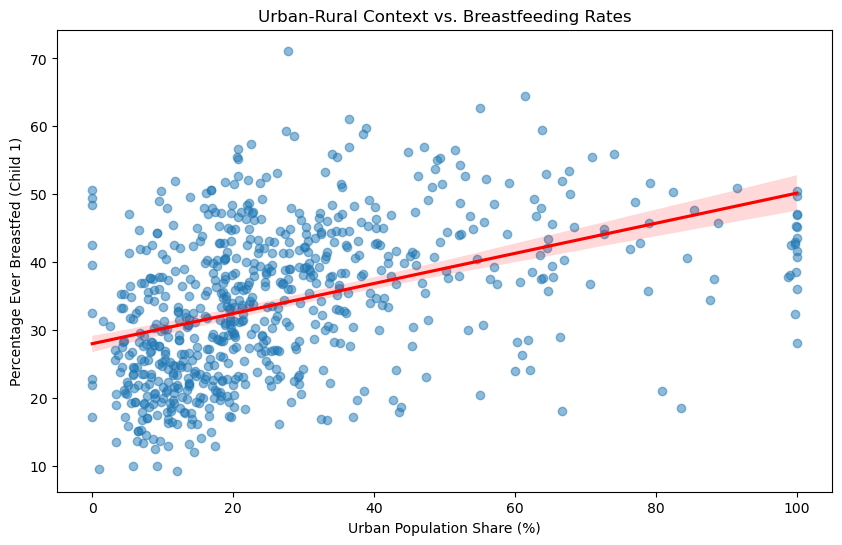

Correlation between Urban Share and Breastfeeding: 0.43


In [2]:
# Scatter plot with regression line
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('ultimate.csv')

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='urban_share_5', y='f_pct_ever_breastfed_c1', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Urban-Rural Context vs. Breastfeeding Rates')
plt.xlabel('Urban Population Share (%)')
plt.ylabel('Percentage Ever Breastfed (Child 1)')
plt.show()

# Correlation
bf_corr = df['urban_share_5'].corr(df['f_pct_ever_breastfed_c1'])
print(f"Correlation between Urban Share and Breastfeeding: {bf_corr:.2f}")

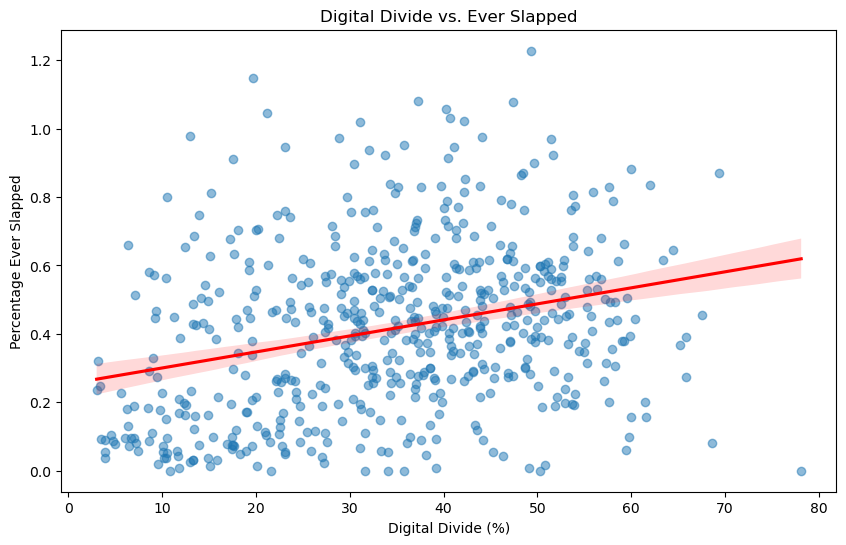

Correlation between Digital Divide and Ever Slapped: 0.29


In [4]:
# Scatter plot with regression line
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('ultimate.csv')

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='dd_mobile_own_5', y='m_slapped', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Digital Divide vs. Ever Slapped')
plt.xlabel('Digital Divide (%)')
plt.ylabel('Percentage Ever Slapped')
plt.show()

# Correlation
bf_corr = df['dd_mobile_own_5'].corr(df['m_slapped'])
print(f"Correlation between Digital Divide and Ever Slapped: {bf_corr:.2f}")

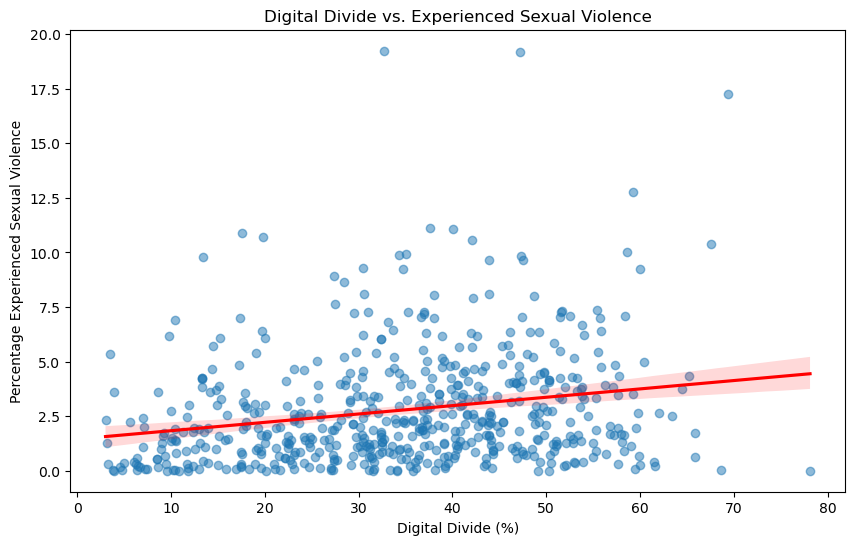

Correlation between Digital Divide and Experienced Sexual Violence: 0.22


In [5]:
# Scatter plot with regression line
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('ultimate.csv')

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='dd_mobile_own_5', y='m_experienced_any_sexual_viol', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Digital Divide vs. Experienced Sexual Violence')
plt.xlabel('Digital Divide (%)')
plt.ylabel('Percentage Experienced Sexual Violence')
plt.show()

# Correlation
bf_corr = df['dd_mobile_own_5'].corr(df['m_experienced_any_sexual_viol'])
print(f"Correlation between Digital Divide and Experienced Sexual Violence: {bf_corr:.2f}")

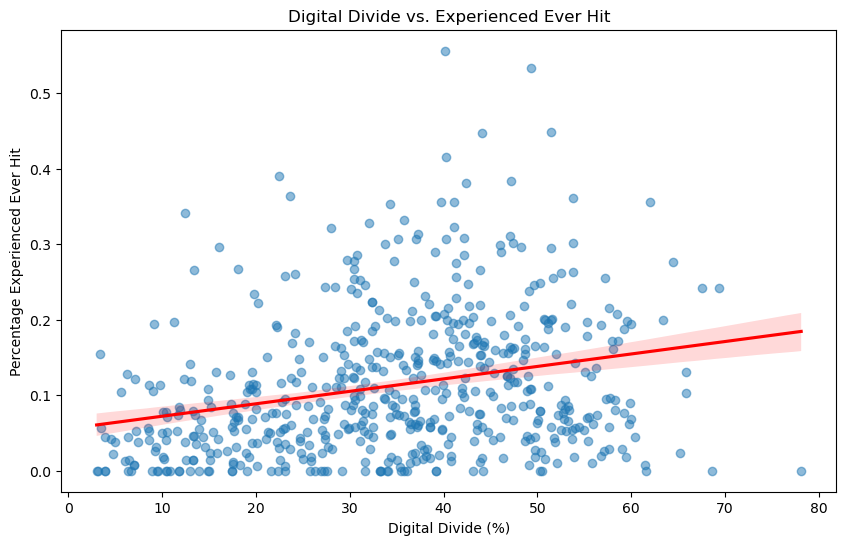

Correlation between Digital Divide and Ever Hit: 0.26


In [6]:
# Scatter plot with regression line
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('ultimate.csv')

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='dd_mobile_own_5', y='m_punched_hit_harmful', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Digital Divide vs. Experienced Ever Hit')
plt.xlabel('Digital Divide (%)')
plt.ylabel('Percentage Experienced Ever Hit')
plt.show()

# Correlation
bf_corr = df['dd_mobile_own_5'].corr(df['m_punched_hit_harmful'])
print(f"Correlation between Digital Divide and Ever Hit: {bf_corr:.2f}")

Regression Table:
                              OLS Regression Results                             
Dep. Variable:     m_punched_hit_harmful   R-squared:                       0.069
Model:                               OLS   Adj. R-squared:                  0.067
Method:                    Least Squares   F-statistic:                     42.33
Date:                   Thu, 27 Nov 2025   Prob (F-statistic):           1.69e-10
Time:                           12:51:44   Log-Likelihood:                 562.40
No. Observations:                    574   AIC:                            -1121.
Df Residuals:                        572   BIC:                            -1112.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

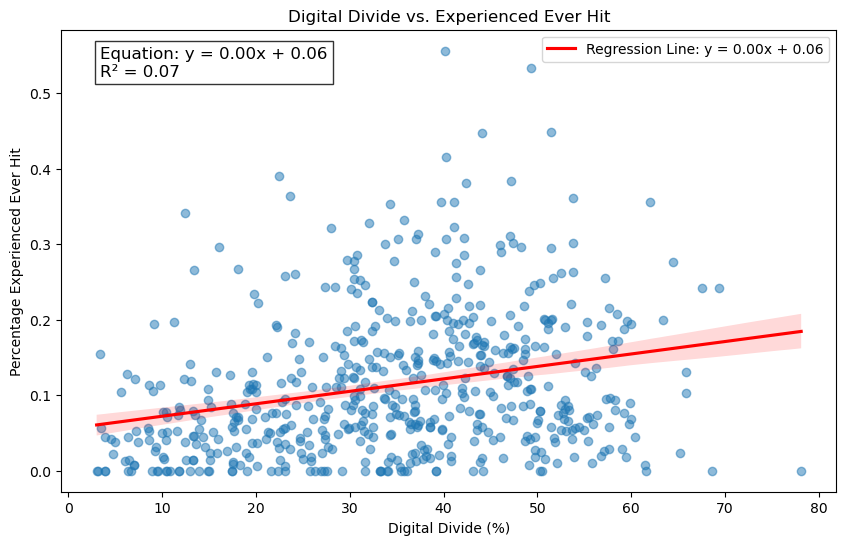


Correlation between Digital Divide and Ever Hit: 0.26


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('ultimate.csv')

# Define the variables
x_col = 'dd_mobile_own_5'
y_col = 'm_punched_hit_harmful'

# Drop rows with missing values in the relevant columns for the regression stats
df_clean = df.dropna(subset=[x_col, y_col])

# --- Regression Analysis using statsmodels ---
# Define X and y
X = df_clean[x_col]
y = df_clean[y_col]

# Add a constant to the independent variable (required for the intercept)
X_with_const = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X_with_const).fit()

# Print the Regression Table
print("Regression Table:")
print(model.summary())

# Extract the slope (m) and intercept (b) for the equation
intercept = model.params['const']
slope = model.params[x_col]
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Create the scatter plot with regression line
sns.regplot(data=df, x=x_col, y=y_col, 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color':'red', 'label': f'Regression Line: {equation}'})

# Add the regression equation to the plot
# transform=plt.gca().transAxes places the text relative to the axes (0,0 is bottom-left, 1,1 is top-right)
plt.text(0.05, 0.90, f'Equation: {equation}\nR² = {model.rsquared:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.title('Digital Divide vs. Experienced Ever Hit')
plt.xlabel('Digital Divide (%)')
plt.ylabel('Percentage Experienced Ever ')
plt.legend()
plt.show()

# --- Correlation ---
bf_corr = df[x_col].corr(df[y_col])
print(f"\nCorrelation between Digital Divide and Ever Hit: {bf_corr:.2f}")

Regression Table:
                                  OLS Regression Results                                 
Dep. Variable:     m_experienced_any_sexual_viol   R-squared:                       0.048
Model:                                       OLS   Adj. R-squared:                  0.046
Method:                            Least Squares   F-statistic:                     28.79
Date:                           Thu, 27 Nov 2025   Prob (F-statistic):           1.17e-07
Time:                                   12:53:51   Log-Likelihood:                -1353.8
No. Observations:                            574   AIC:                             2712.
Df Residuals:                                572   BIC:                             2720.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975

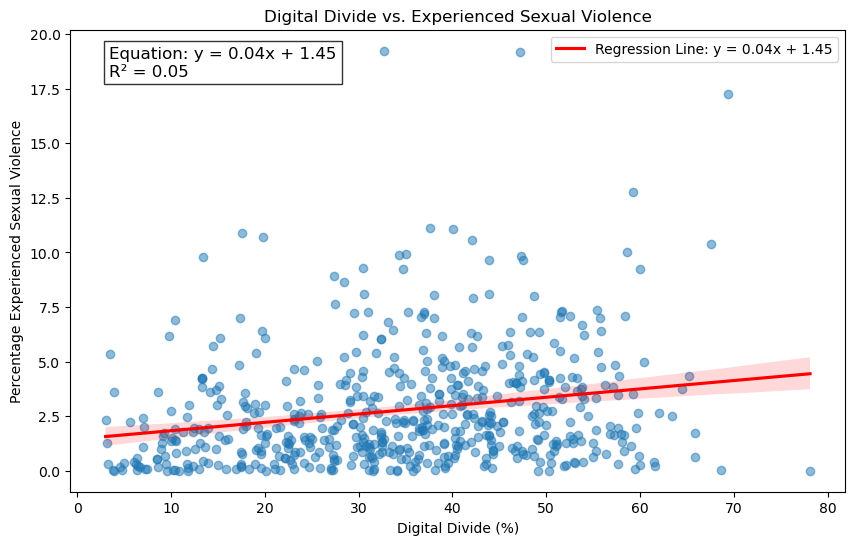


Correlation between Digital Divide and Ever Hit: 0.22


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('ultimate.csv')

# Define the variables
x_col = 'dd_mobile_own_5'
y_col = 'm_experienced_any_sexual_viol'

# Drop rows with missing values in the relevant columns for the regression stats
df_clean = df.dropna(subset=[x_col, y_col])

# --- Regression Analysis using statsmodels ---
# Define X and y
X = df_clean[x_col]
y = df_clean[y_col]

# Add a constant to the independent variable (required for the intercept)
X_with_const = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X_with_const).fit()

# Print the Regression Table
print("Regression Table:")
print(model.summary())

# Extract the slope (m) and intercept (b) for the equation
intercept = model.params['const']
slope = model.params[x_col]
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Create the scatter plot with regression line
sns.regplot(data=df, x=x_col, y=y_col, 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color':'red', 'label': f'Regression Line: {equation}'})

# Add the regression equation to the plot
# transform=plt.gca().transAxes places the text relative to the axes (0,0 is bottom-left, 1,1 is top-right)
plt.text(0.05, 0.90, f'Equation: {equation}\nR² = {model.rsquared:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.title('Digital Divide vs. Experienced Sexual Violence')
plt.xlabel('Digital Divide (%)')
plt.ylabel('Percentage Experienced Sexual Violence')
plt.legend()
plt.show()

# --- Correlation ---
bf_corr = df[x_col].corr(df[y_col])
print(f"\nCorrelation between Digital Divide and Ever Hit: {bf_corr:.2f}")

Regression Table:
                            OLS Regression Results                            
Dep. Variable:              m_slapped   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     51.96
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           1.80e-12
Time:                        12:56:26   Log-Likelihood:                 21.665
No. Observations:                 574   AIC:                            -39.33
Df Residuals:                     572   BIC:                            -30.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.25

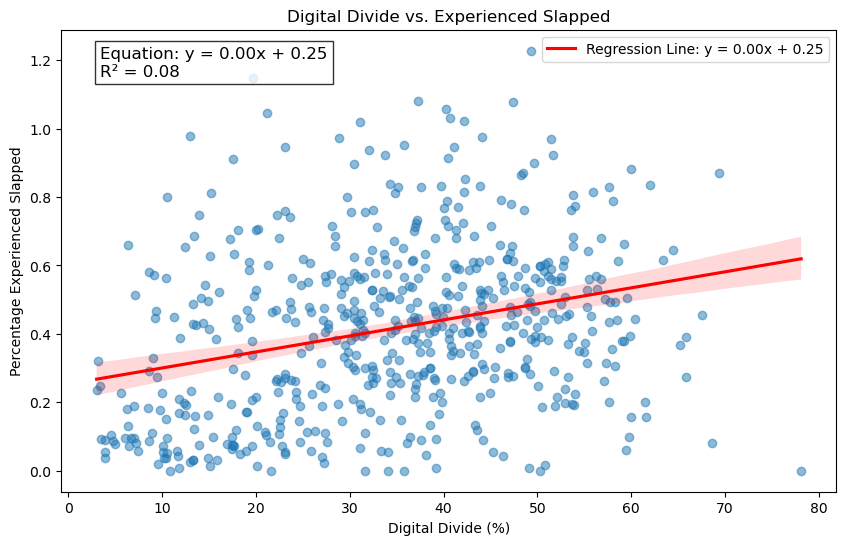


Correlation between Digital Divide and Experienced Slapped: 0.29


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('ultimate.csv')

# Define the variables
x_col = 'dd_mobile_own_5'
y_col = 'm_slapped'

# Drop rows with missing values in the relevant columns for the regression stats
df_clean = df.dropna(subset=[x_col, y_col])

# --- Regression Analysis using statsmodels ---
# Define X and y
X = df_clean[x_col]
y = df_clean[y_col]

# Add a constant to the independent variable (required for the intercept)
X_with_const = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X_with_const).fit()

# Print the Regression Table
print("Regression Table:")
print(model.summary())

# Extract the slope (m) and intercept (b) for the equation
intercept = model.params['const']
slope = model.params[x_col]
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Create the scatter plot with regression line
sns.regplot(data=df, x=x_col, y=y_col, 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color':'red', 'label': f'Regression Line: {equation}'})

# Add the regression equation to the plot
# transform=plt.gca().transAxes places the text relative to the axes (0,0 is bottom-left, 1,1 is top-right)
plt.text(0.05, 0.90, f'Equation: {equation}\nR² = {model.rsquared:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.title('Digital Divide vs. Experienced Slapped')
plt.xlabel('Digital Divide (%)')
plt.ylabel('Percentage Experienced Slapped')
plt.legend()
plt.show()

# --- Correlation ---
bf_corr = df[x_col].corr(df[y_col])
print(f"\nCorrelation between Digital Divide and Experienced Slapped: {bf_corr:.2f}")

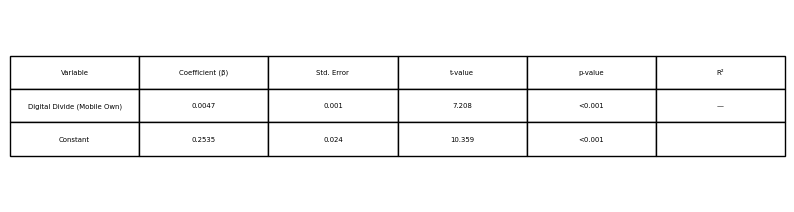

In [5]:
import matplotlib.pyplot as plt

# Your regression data
data = [
    ["Digital Divide (Mobile Own)", "0.0047", "0.001", "7.208", "<0.001", "—"],
    ["Constant", "0.2535", "0.024", "10.359", "<0.001", ""]
]

columns = ["Variable", "Coefficient (β)", "Std. Error", "t-value", "p-value", "R²"]

fig, ax = plt.subplots(figsize=(10, 2.5))
ax.axis('off')

# Create table
table = ax.table(
    cellText=data,
    colLabels=columns,
    cellLoc='center',
    loc='center'
)

table.scale(1, 2)

# Save image
plt.savefig("regression_table.png", dpi=300, bbox_inches='tight')


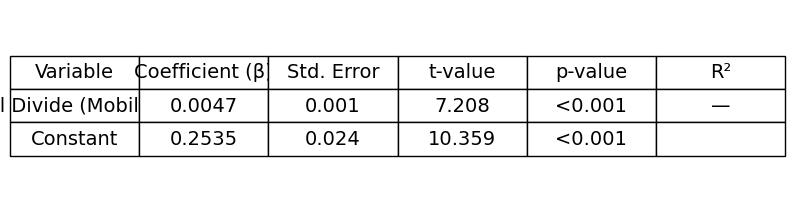

In [6]:
import matplotlib.pyplot as plt

# Your regression data
data = [
    ["Digital Divide (Mobile Own)", "0.0047", "0.001", "7.208", "<0.001", "—"],
    ["Constant", "0.2535", "0.024", "10.359", "<0.001", ""]
]

columns = ["Variable", "Coefficient (β)", "Std. Error", "t-value", "p-value", "R²"]

fig, ax = plt.subplots(figsize=(10, 2.5))
ax.axis('off')

# Create table
table = ax.table(
    cellText=data,
    colLabels=columns,
    cellLoc='center',
    loc='center'
)

# 🔥 Increase font size
table.auto_set_font_size(False)
table.set_fontsize(14)   # increase this number if you want bigger

table.scale(1, 2)

# Save image
plt.savefig("regression_table.png", dpi=300, bbox_inches='tight')


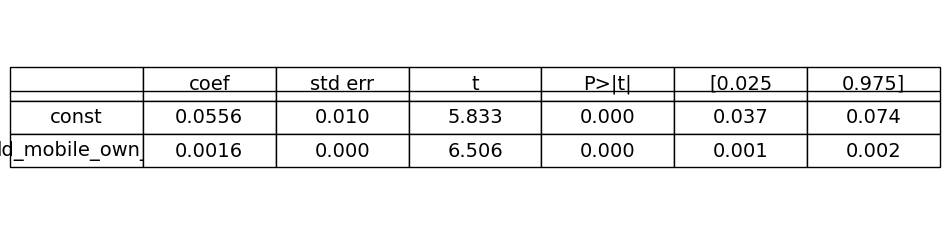

In [8]:
import matplotlib.pyplot as plt

# Regression data
data = [
    ["const", "0.0556", "0.010", "5.833", "0.000", "0.037", "0.074"],
    ["dd_mobile_own_5", "0.0016", "0.000", "6.506", "0.000", "0.001", "0.002"]
]

columns = ["", "coef", "std err", "t", "P>|t|", "[0.025", "0.975]"]

fig, ax = plt.subplots(figsize=(12, 2.8))
ax.axis("off")

# Create table
table = ax.table(
    cellText=data,
    colLabels=columns,
    cellLoc="center",
    loc="center"
)

# Font size
table.auto_set_font_size(False)
table.set_fontsize(14)

# Row height
table.scale(1, 2)

# Add horizontal separator line (Stata-style)
plt.axhline(y=0.62, color='black', linewidth=1)

# Save image
plt.savefig("stata_style_table.png", dpi=300, bbox_inches="tight")
